#  Weather in AUS
#### Hila Dar, Dec 2021

1. [Introduction](#Introduction)

    1.1 [Problem definition](#1.1)
    
    1.2 [Dataset](#1.2)
    
    1.3 [Libraries](#1.3)
    
    1.4 [Loading the Data](#1.4)
    
2. [Data Analysis and Data Visualization](#Data_Analysis_and_Data_Visualization)

    2.1 [Simple Data Analysis](#2.1)
    
    2.2 [Analyze by visualizing data](#2.2)
    
    2.3

# Introducation <a class="anchor" id="Introduction"></a> <a class="tocSkip">

### Problem definition <a class="anchor" id="1.1"></a>
Our goal is to predict next-day rainfall in Australia using location specific data. 

The Dataset contains 10 years of daily weather observations from different locations in Australia. 
These observations have been taken from the Bureau of Meteorology's "real time" system. Most of the data are generated and handled automatically. Some quality checking has been performed, but it is still possible for erroneous values to appear.

##### Libraries  <a class="anchor" id="1.3"></a>

In [17]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [18]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from datetime import datetime
import folium

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# map
from geopy.geocoders import Nominatim
import re


# machine learning
from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

#warnings 
pd.options.mode.chained_assignment = None  # default='warn'



CMAP = 'vlag'
fontfamily = "monospace"
context = "notebook"
color = 'gold'
rc = {'axes.titlesize':18, 'axes.titleweight':'bold',
      'axes.labelweight':'bold', 'figure.figsize':[12,8], 
      'lines.linewidth':5, 'axes.edgecolor':'black',
     'boxplot.boxprops.color': color}

sns.set(context=context, font=fontfamily, rc=rc, style="whitegrid")
sns.set_palette(CMAP)

##### Loading the Data <a class="anchor" id="1.4"></a>

In [8]:
# loading the data
data_path = "./weatherAus.csv"
data = pd.read_csv(data_path)
print(f"there are {data.duplicated().sum()} duplicated data-points")

# simple pre processing
def to_datetime(stry):
    """ converts date to datetime """
    time = stry.split('-')
    year,month,day = int(time[0]), int(time[1]),int(time[2])
    return datetime(year = year, month=month, day=day).date()

data["Date"] = data["Date"].apply(to_datetime) # converts to datetime
data = data.sort_values("Date")  # sorts by date
data = data.set_index('Date')    # sets index
data = data.replace(to_replace=["Yes","No"], value = [1,0])  # converts bool to int

# split to y-label and train and test.
y_label = 'RainTomorrow'
train, test = train_test_split(data, test_size=0.2, random_state=1)

there are 0 duplicated data-points


# Exploratory data analysis & Data Visualization <a class="anchor" id="Data_Analysis_and_Data_Visualization"></a>

## Simple Data Analysis <a class="anchor" id="2.1"></a>

### Features Dictionary
| Feature       | Description                                                                                                         | Units               |
|:---------------|:---------------------------------------------------------------------------------------------------------------------|:---------------------|
| Date          | The date of observation                                                                                             | yyyy-mm-dd          |
| Location      | The common name of the location of the weather station                                                              |                     |
| MinTemp       | Minimum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree                        | degrees Celsius     |
| MaxTemp       | Maximum temperature in the 24 hours from 9am. Sometimes only known to the nearest whole degree.                     | degrees Celsius     |
| Rainfall      | Precipitation (rainfall) in the 24 hours to 9am. Sometimes only known to the nearest whole millimetre.              | millimetres         |
| Evaporation   | "Class A" pan evaporation in the 24 hours to 9am                                                                    | millimetres         |
| Sunshine      | The number of hours of bright sunshine in the day.| hours               |
| WindGustDir   | Direction of strongest gust in the 24 hours to midnight                                                             | 16 compass points   |
| WindGustSpeed | Speed of strongest wind gust in the 24 hours to midnight                                                            | kilometres per hour |
| WindDir9am    | Wind direction averaged over 10 minutes prior to 9 am                                                               | 16 compass points   |
| WindDir3pm    | Wind direction averaged over 10 minutes prior to 3 pm                                                               | 16 compass points   |
| WindSpeed9am  | Wind speed averaged over 10 minutes prior to 9 am                                                                   | kilometres per hour |
| WindSpeed3pm  | Wind speed averaged over 10 minutes prior to 3 pm                                                                   | kilometres per hour |
| Humidity9am   | Relative humidity at 9 am                                                                                           | percent             |
| Humidity3pm   | Relative humidity at 3 pm                                                                                           | percent             |
| Pressure9am   | Atmospheric pressure reduced to mean sea level at 9 am                                                              | hectopascals        |
| Pressure3pm   | Atmospheric pressure reduced to mean sea level at 3 pm                                                              | hectopascals        |
| Cloud9am      | Fraction of sky obscured by cloud at 9 am                                                                           | eighths             |
| Cloud3pm      | Fraction of sky obscured by cloud at 3 pm                                                                           | eighths             |
| Temp9am       | Temperature at 9 am                                                                                                 | degrees Celsius     |
| Temp3pm       | Temperature at 3 pm                                                                                                 | degrees Celsius     |
| RainToday     | 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0                                             | Boolean             |
| RainTomorrow     | The feature we are trying to predict - 1 if precipitation (mm) in the next 24 hours to 9am exceeds 1mm, otherwise 0 | Boolean             |


#### Which features are categorical? Which features are numerical?

In [9]:
categorial_features = train.select_dtypes(include=['object']).columns.tolist()
numerical_features = train.select_dtypes(exclude=['object']).columns.tolist()

print(f'Categorical features: {categorial_features}')
print(f'Numerical features: {numerical_features}')

Categorical features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
Numerical features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


#### Which features contain blank, null or empty values?
* There are many missing data points in this dataset, particularly in some features such as Sunshine and Evaporation.
* As shown below, some features are missing as a whole for some locations.
* Null values have no predictive power of whether it is going to rain.

In [10]:
# checking correaltion between missing values and y_label
tmp = (train.isnull().sum().sort_values(ascending=False)/(train.shape[0]))
features_with_many_nan_values = tmp[tmp > 0.2].index
tmpy = train[~train[y_label].isnull()].copy()

    # checking null values per features: 
null_train = (train.isnull().sum().sort_values(ascending=False)/(train.shape[0])).round(2)
null_test = (test.isnull().sum().sort_values(ascending=False)/(test.shape[0])).round(2)


for feature in features_with_many_nan_values:
    tmpy["{}_is_null".format(feature)] = tmpy[feature].apply(lambda x:1 if pd.isnull(x) else 0)
    corr = np.corrcoef(tmpy["{}_is_null".format(feature)],tmpy[y_label])[0][1]
    print(f"correlation between {feature}_is_null and y_label = {corr:.2f}")
pd.DataFrame({"%-missing values - Train":null_train,"%-missing values - Test":null_test}).sort_values("%-missing values - Train", ascending=False).head(15)


correlation between Sunshine_is_null and y_label = -0.01
correlation between Evaporation_is_null and y_label = 0.01
correlation between Cloud3pm_is_null and y_label = -0.04
correlation between Cloud9am_is_null and y_label = -0.03


%-missing values - Train  %-missing values - Test
Sunshine                           0.48                     0.48
Evaporation                        0.43                     0.43
Cloud3pm                           0.41                     0.40
Cloud9am                           0.38                     0.38
Pressure3pm                        0.10                     0.10
Pressure9am                        0.10                     0.10
WindGustSpeed                      0.07                     0.07
WindGustDir                        0.07                     0.07
WindDir9am                         0.07                     0.08
Humidity3pm                        0.03                     0.03
WindDir3pm                         0.03                     0.03
Temp3pm                            0.03                     0.02
WindSpeed3pm                       0.02                     0.02
RainTomorrow                       0.02                     0.02
Rainfall                           0.02                     0.02

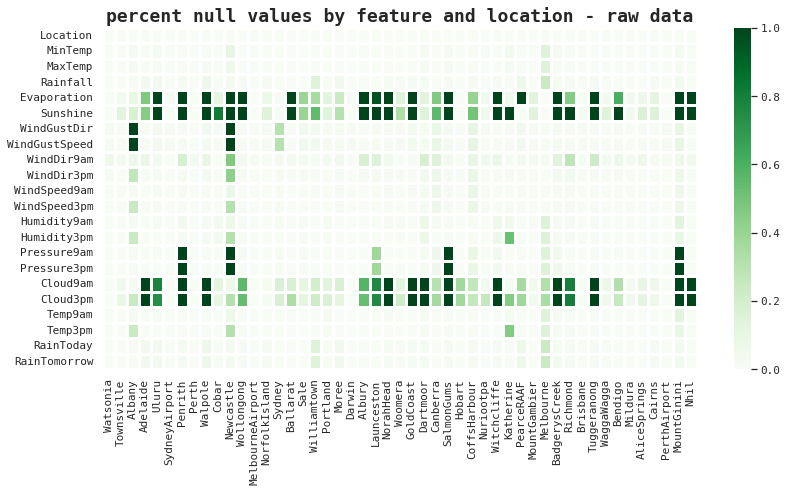

In [11]:
def plot_nan_heatmap(dff, title_surfix):
    """ ploting percent nan values per location and field """
    title = "percent null values by feature and location - " + title_surfix
    tmp = {}
    all_locations = dff.Location.unique()
    for location in all_locations:
        tmp[location] = dff[dff['Location']==location].isnull().sum()/dff[dff['Location']==location].shape[0]
    plt.figure(figsize=(12,7))
    ax = sns.heatmap(pd.DataFrame(tmp ,index = dff.columns),xticklabels=all_locations,linewidths=3, cmap='Greens')
    ax.set_title(title)
    ax.figure.tight_layout()
    plt.savefig(f"./images/{title}.png") 
    
plot_nan_heatmap(train, "raw data")

## Analyze by visualizing data <a class="anchor" id="2.2"></a>

### Features Distribution  & Joint Distribution<a class="anchor" id="2.2.2"></a>

* Temperature and pressure variables are normally distributed.
* Wind speed, evaporation and rainfall variables are right skewed.
* Some variables varies during the day (Wind direction, temprature) and some doesn't vary significantly (cloudiness, pressure, humidity).
* Sunshine and humidity distributions, changes significantly while conditioning our y label.
* our dataset is imbalanced - Most days (78%) it wasn't raining on the next day.

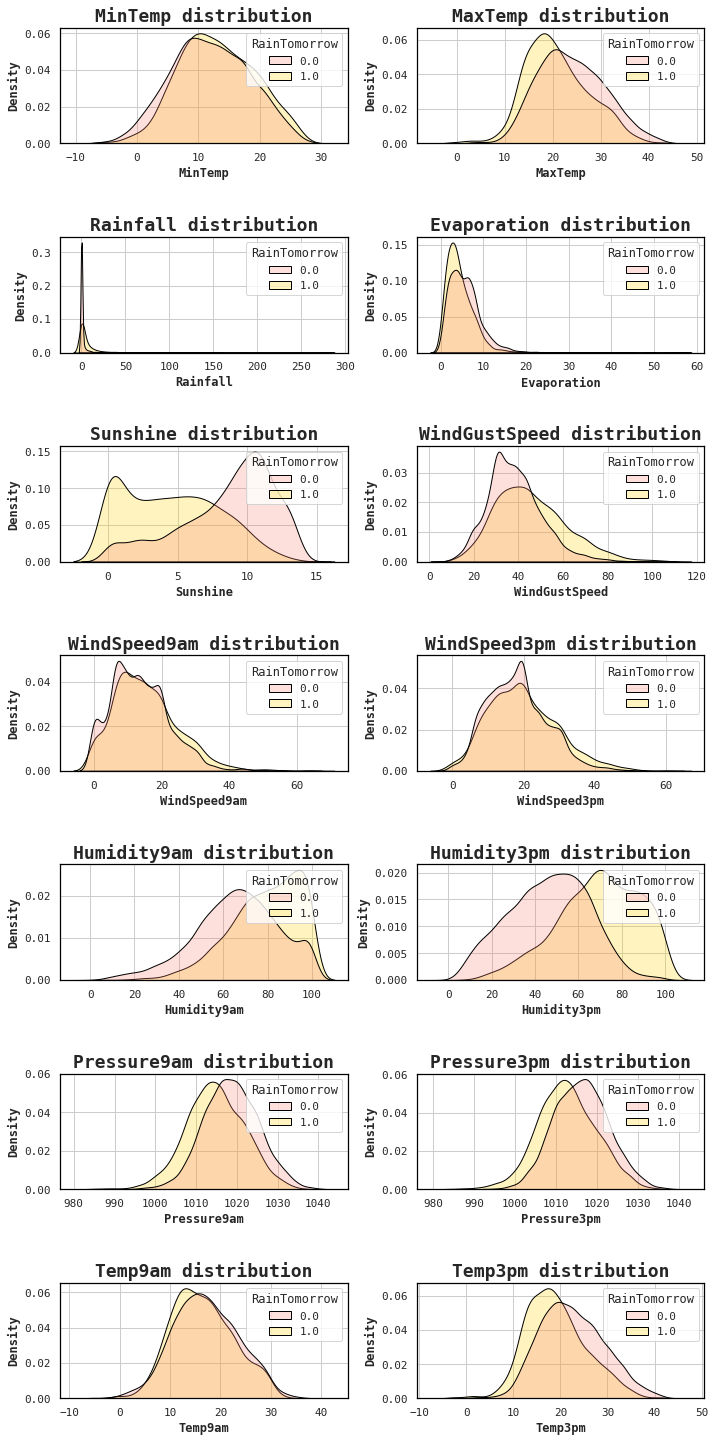

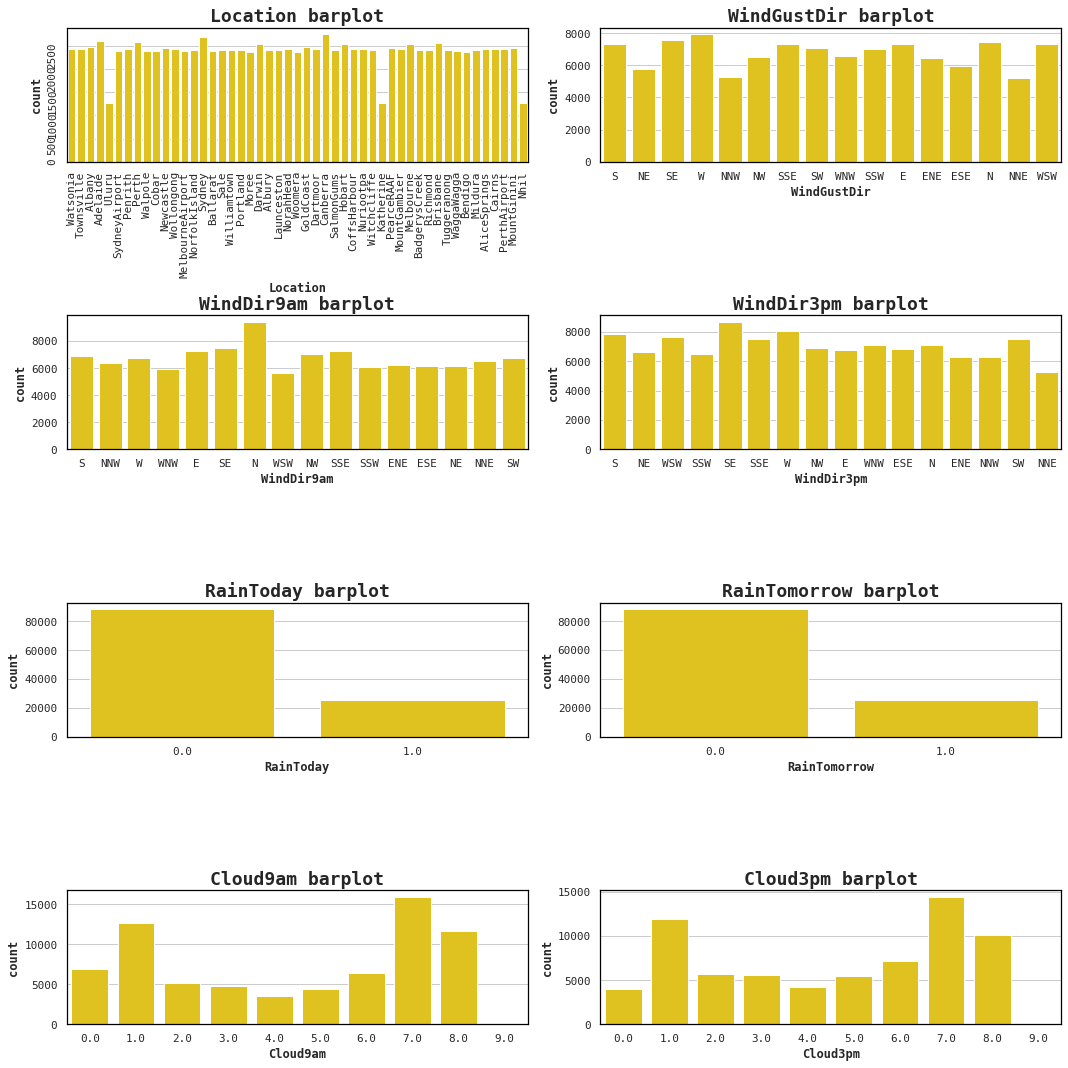

In [12]:
#Dist plot of all numberical features
fig, ax = plt.subplots(ncols=2, nrows=7, figsize=(10,20))
index = 0
ax = ax.flatten()
title = "numerical features distribution"
sample = train.sample(10000).reset_index()

for col, value in sample.select_dtypes('number').items():
    if col not in ['RainToday', 'RainTomorrow', 'Cloud3pm','Cloud9am',"Date"]:
        sns.kdeplot(data=sample, x=col,common_norm=False,hue=y_label,
                    palette={1:"gold",0:"salmon"},shade=True, edgecolor="black",
                    ax=ax[index]).set_title(f"{col} distribution", weight="bold")
        index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=3.0)
plt.savefig(f"./images/{title}.png") 

#Dist plot of all categorial features
# plots settings:
title = "categorial features distribution"
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(15,15))
index = 0
ax = ax.flatten()

categorical_features = [col for col in list(train.select_dtypes('object').columns) if col!='Date'] + ['RainToday', 'RainTomorrow', 'Cloud9am', 'Cloud3pm']
for col in categorical_features:
    sns.countplot(x=col, data=train,ax=ax[index],alpha=1,color=color)
    ax[index].set_title(f"{col} barplot")
    ax[index].set_xlabel(f"{col}", weight="bold")
    ax[index].set_ylabel("count", weight="bold")
    index += 1
ax[0].tick_params(labelrotation=90)
plt.tight_layout(h_pad=0.0001)
plt.savefig(f"./images/{title}.png") 

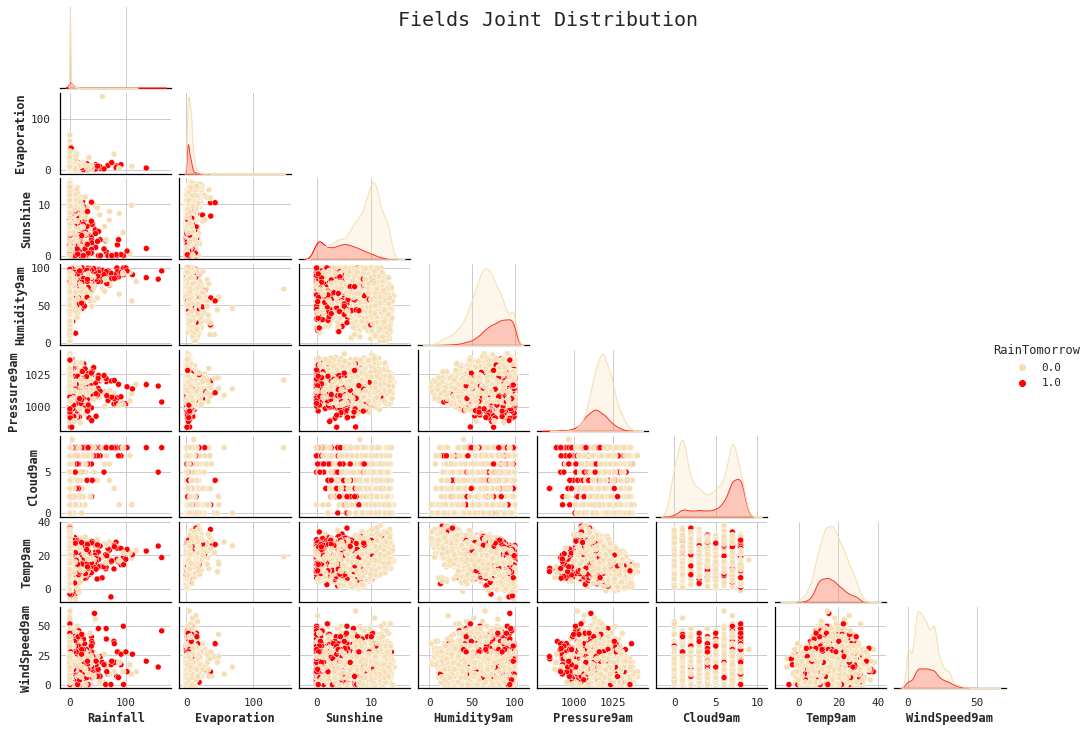

In [19]:
# select only a subset of fields to visualize 
sample_features = [
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'Humidity9am',
 'Pressure9am',
 'Cloud9am',
 'Temp9am',
 'WindSpeed9am']
data_sample = train[sample_features+[y_label]].reset_index().sample(10000)

title = "Fields Joint Distribution"
f = sns.pairplot(data=data_sample,
                 vars=(sample_features),
                 hue=y_label,
                 palette={1:"red",0:"wheat"}, 
                 diag_kind = 'kde',
             corner=True)
f.fig.set_size_inches(15,10)
f.fig.suptitle(title, fontsize=20)
plt.savefig(f"./images/{title}.png") 

### Features Correlation <a class="anchor" id="2.2.2"></a>

* Many of our features such as temperature, pressure, cloud, windspeed and humidity, have correalation between their morning and afternoon values.
* The most linear correlated features with RainTomorrow are: Sunshine (-0.45), Humidity3pm (0.45), Cloud3pm(0.38),Cloud9am (0.32) and RainToday (0.31).

The most linear correlated features with RainTomorrow are:
Sunshine          -->  0.45 (abs)
Humidity3pm       -->  0.45 (abs)
Cloud3pm          -->  0.38 (abs)
Cloud9am          -->  0.32 (abs)
RainToday         -->  0.31 (abs)
Humidity9am       -->  0.26 (abs)
Pressure9am       -->  0.25 (abs)
Rainfall          -->  0.24 (abs)
WindGustSpeed     -->  0.23 (abs)
Pressure3pm       -->  0.23 (abs)


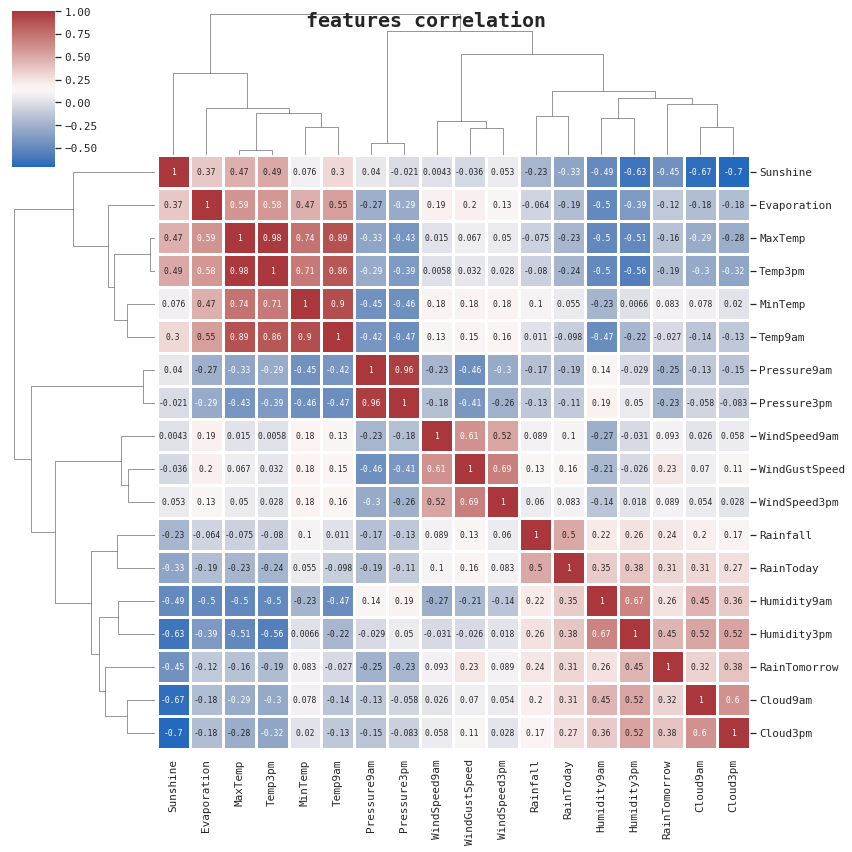

In [14]:
def plot_features_correlation(dff,title = "features correlation"):
    ax = sns.clustermap(dff.corr(), annot=True, cmap='vlag',fmt='.2g',linewidths=3, figsize=(12,12), annot_kws={"fontsize":8})
    if y_label in dff.columns:
        series = np.abs(dff.corr()[y_label]).sort_values(ascending=False)
        print('The most linear correlated features with RainTomorrow are:')
        for i, row in enumerate(series):
            if 0.2 <= row < 1:
              print(f'{series.index[i]:17} --> {row: .2f} (abs)')
    ax.fig.suptitle(title, fontsize=20, weight="bold")
    plt.savefig(f"./images/{title}.png") 
plot_features_correlation(train)

### Location analysis<a class="anchor" id="2.2.3"></a>

* Most observations were taken from south east Australia (which is also the most populated area in Australia). 
* Distribuations of features varies accross locations, as expected - the locations of the stations belongs to different climate zones. 
* If we look at the avarege dailly temprature range per location, we see that desert locations have the largest range, while coastal regions seem to be a bit more stable.

In [21]:
#Locations of the observations, with average rainfall per location.

geolocator = Nominatim(user_agent="hila_dar")
all_locations = train.Location.unique()
rows = []
for location in all_locations:
    fixed_location = re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', location) #Some location names in the data composed of 2 words, but missing the space between them. 
    address = f'{fixed_location}, Australia' 
    loc = geolocator.geocode(address)
    if loc:
        rows.append([location, loc.latitude, loc.longitude])
    else:
        rows.append([location, None, None])
        
locations_df = pd.DataFrame(rows, columns = ['Location', 'lat','long']).set_index('Location')
locations_df = pd.concat([train.groupby('Location').agg({'Rainfall':'mean'}), locations_df],axis=1, join='inner')

m = folium.Map(location = [-29, 151.2], tiles ='OpenStreetMap', zoom_start=4)
for index, row in locations_df.iterrows():
   folium.Circle(
      location=[row['lat'], row['long']],
      popup=index,
      radius=float(row['Rainfall'])*20000,
      color='crimson',
      #fill=True,
      fill_color='crimson'
   ).add_to(m)
m



GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Watsonia%2C+Australia&format=json&limit=1 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7fa0a43455e0>, 'Connection to nominatim.openstreetmap.org timed out. (connect timeout=1)'))

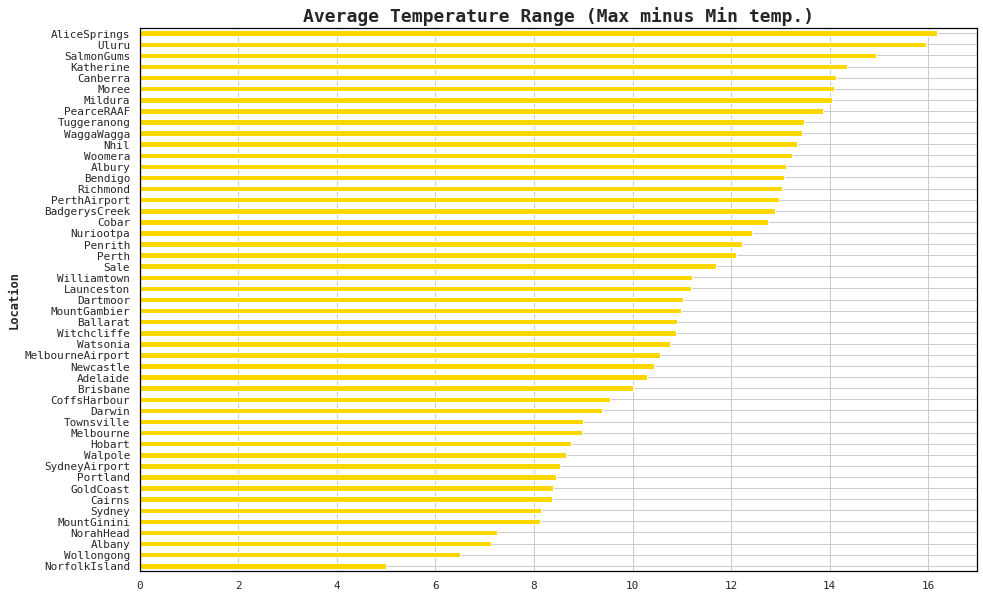

In [22]:
# plot dailly range of tempreature by location (Max temp minus Min temp) 
tmp = train
tmp["dailly_range"] = tmp['MaxTemp']-tmp['MinTemp']
temp_avg = tmp.groupby(['Location']).mean()
temp_avg.sort_values(by='dailly_range', ascending=True)['dailly_range'].plot(kind='barh', figsize=(15,10),color=color,title="Average Temperature Range (Max minus Min temp.)")
plt.savefig(f"./images/{title}.png") 
plt.show()

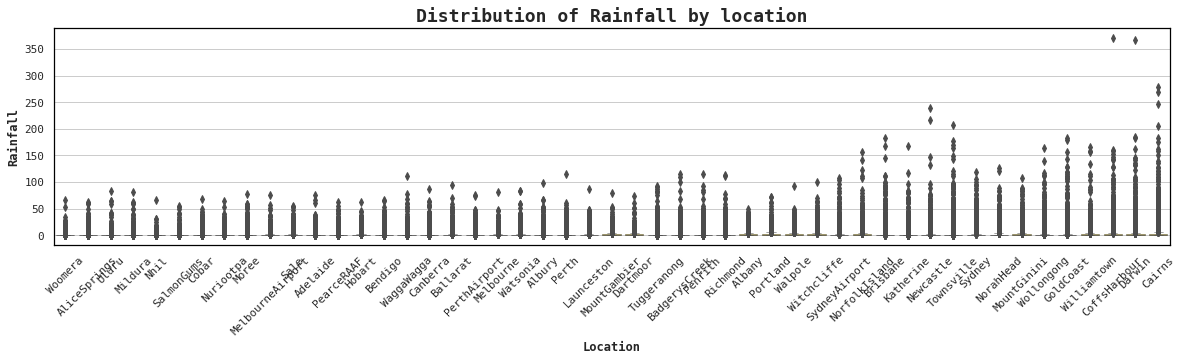

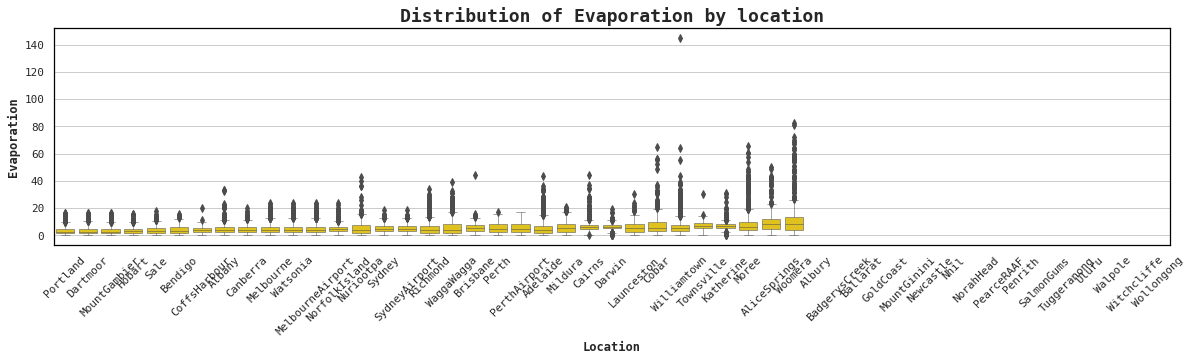

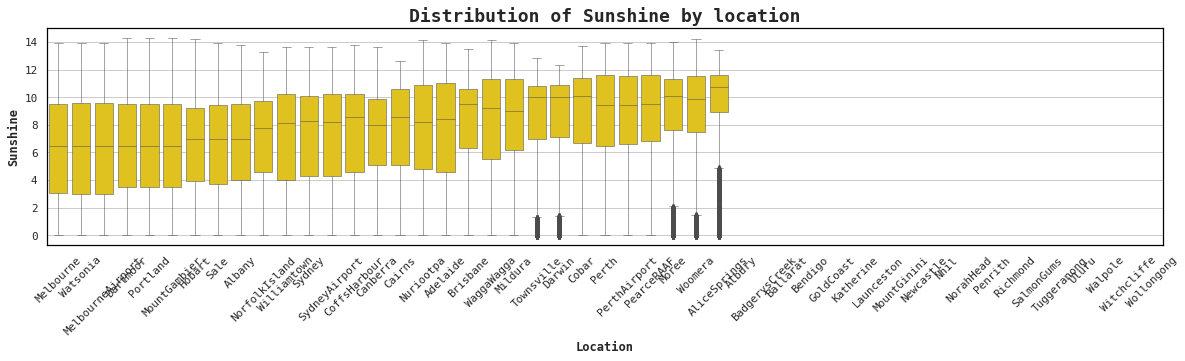

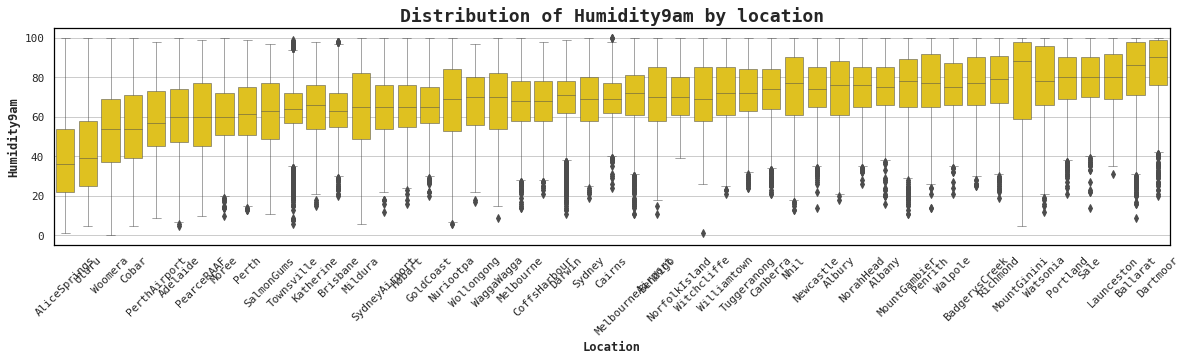

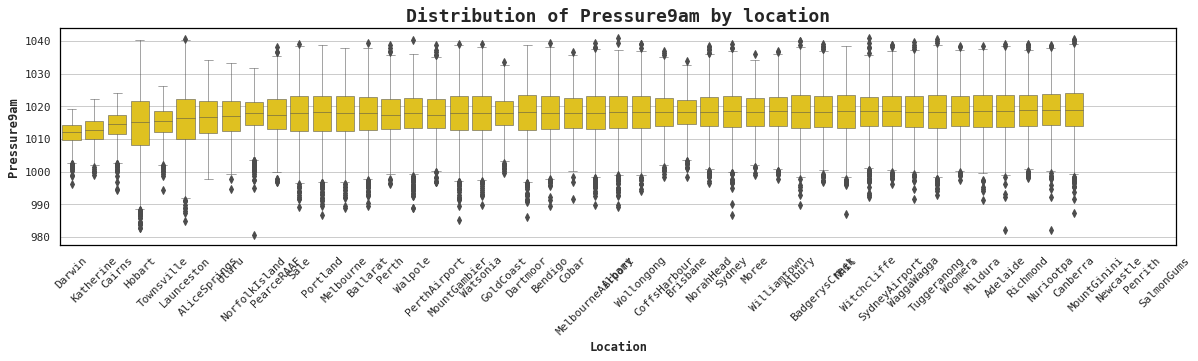

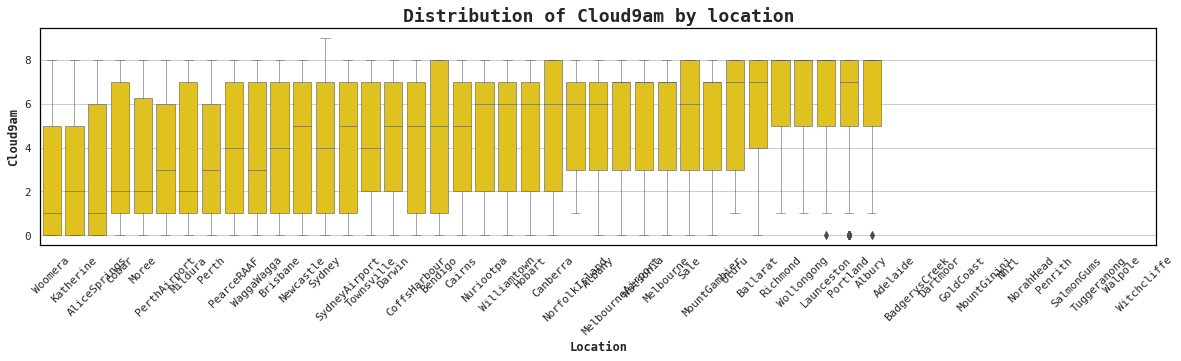

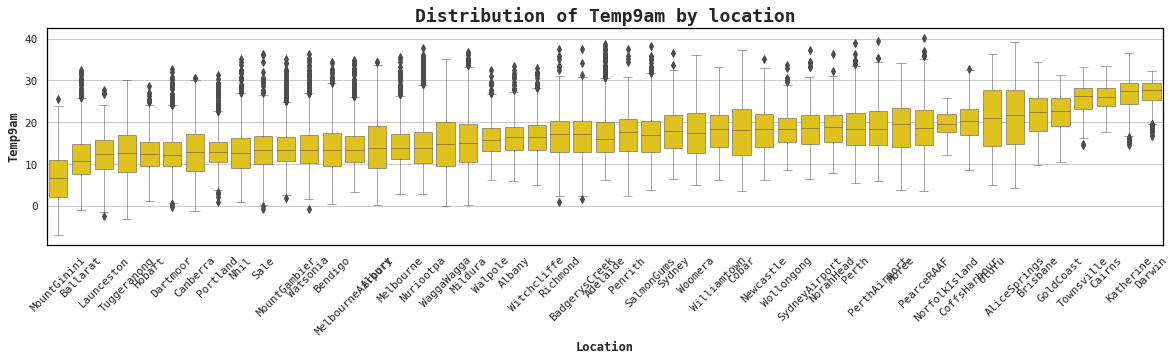

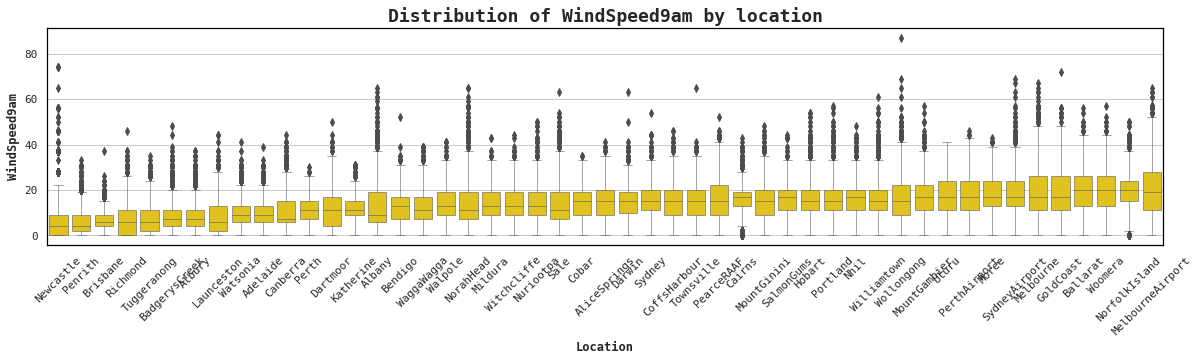

In [23]:
def plot_field_dist_by_location(field):
    #plot settings:
    plt.figure(figsize=(20,4))
    my_order = train.groupby('Location')[field].mean().sort_values().index
    plt.xticks(rotation=45)

    title = "Distribution of {} by location".format(field)
    sns.boxplot(x="Location", y=field, data=train,order=my_order,color=color,linewidth=0.5).set_title(title)
for field in sample_features:
    plot_field_dist_by_location(field)

### Time series analysis<a class="anchor" id="2.2.4"></a>

* Most features are seasonal, as we might expect.
* Average Dailly rainfall is noisy with no obvious trends (RainTomorrow, our y_label, is 1 if the precipitation on the next day exceeds 1 mm). This is not unexpected as we’ve averaged across the entire locations universe.

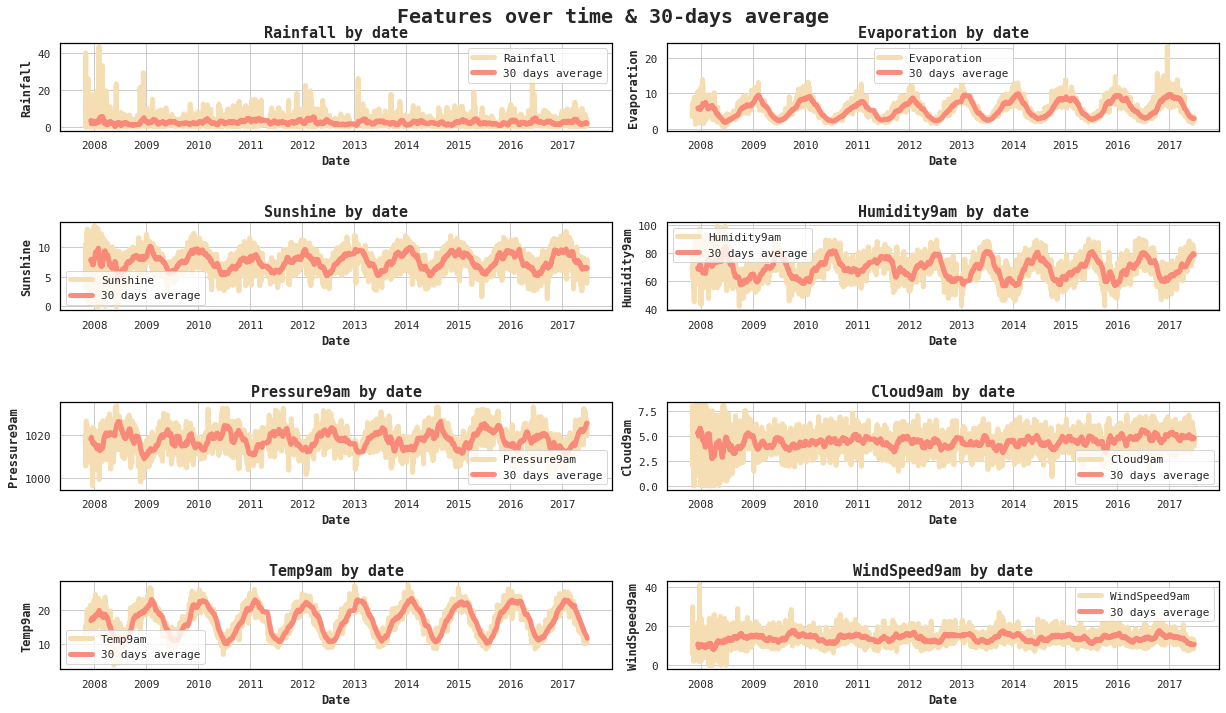

In [24]:
def plot_a_field_over_time(feature, ax, low_pass_filter_window = 30):
    """ plots the average value amoung different locations of a field over time """
    #plot settings:
    field_ts = train.groupby("Date")[field].mean()
    
    title = f"{field} by date"
    sns.lineplot(data=field_ts.rolling(1).mean(), label = feature,ax=ax,color='wheat').set_title(title,fontsize=15)
    sns.lineplot(data=field_ts.rolling(low_pass_filter_window).mean(), label = f"{low_pass_filter_window} days average",ax=ax,color='salmon',alpha=0.9)

    
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(17,10))
title = 'Features over time & 30-days average'
fig.suptitle(title, fontsize=20, weight='bold')
index = 0
ax = ax.flatten()

for field in sample_features:
    plot_a_field_over_time(field,ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=3.0)
plt.savefig(f"./images/{title}.png") 



## Preprocessing

#### Correcting <a class="anchor" id="3.1"></a>
First we transform the categorical wind-direction data into numeric features. Ideally, this transformation $f: [0, 2\pi] \rightarrow\mathbb{R}^{n}$ should have three important properties:

1. f is a continues.
2. $f(0)=f(2\pi)$
3. f is one-to-one, ie angle1!= angle2 then f(angle1)!=f(angle2).

I choose to apply the following map:

$f: f(\theta) = (\sin(\theta), \cos(\theta))$

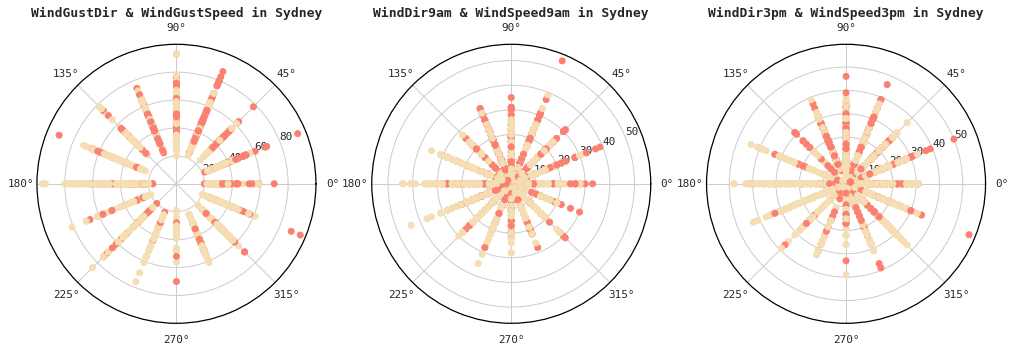

<Figure size 864x576 with 0 Axes>

In [27]:
d = {"E": 0,
     "ESE": 22.5,
     "SE": 45,
     "SSE": 67.5,
     "S": 90,
     "SSW": 112.5,
     "SW": 135,
     "WSW": 157.5,
     "W": 180,
     "WNW": 202.5,
     "NW": 225,
     "NNW": 247.5,
     "N": 270,
     "NNE": 292.5,
     "NE": 315,
     "ENE": 337.5}

def f(v):
    return v* (np.pi/180)

d = dict((k, f(v)) for k, v in d.items())
train.replace(to_replace=list(d.keys()), value = list(d.values()), inplace = True)
test.replace(to_replace=list(d.keys()), value = list(d.values()), inplace = True)

# plotting dist of wind-dir and wind speed:
title = "wind direction & speed"

colors = {1.0:'tab:blue', 0.0:'tab:orange'}
fig= plt.figure(figsize=(17,10))
ax1 = plt.subplot(131, projection='polar')
ax2 = plt.subplot(132, projection='polar')
ax3 = plt.subplot(133, projection='polar')


location = 'Sydney'
tmp = train[train['Location']==location]
my_colors = tmp[y_label].apply(lambda x: "salmon" if x==1 else "wheat")
ax1.scatter(x=tmp['WindGustDir'], y=tmp['WindGustSpeed'], c=my_colors)
ax2.scatter(x=tmp['WindDir9am'], y=tmp['WindSpeed9am'], c=my_colors)
ax3.scatter(x=tmp['WindDir3pm'], y=tmp['WindSpeed3pm'], c=my_colors)


title = "Wind"
ax1.set_title(f'WindGustDir & WindGustSpeed in {location}', fontsize=13)
ax2.set_title(f'WindDir9am & WindSpeed9am in {location}',fontsize=13)
ax3.set_title(f'WindDir3pm & WindSpeed3pm in {location}',fontsize=13)

plt.show()
plt.savefig(f"./images/{title}.png") 

wind_dir_features= ['WindGustDir', 'WindDir9am', 'WindDir3pm']
for feature in wind_dir_features:
    train[f"{feature}_sin"] = train[feature].apply(lambda x: np.sin(x))
    train[f"{feature}_cos"] = train[feature].apply(lambda x: np.cos(x))
    test[f"{feature}_sin"] = test[feature].apply(lambda x: np.sin(x))
    test[f"{feature}_cos"] = test[feature].apply(lambda x: np.cos(x))

train.drop(labels=wind_dir_features ,axis=1, inplace=True)
test.drop(labels=wind_dir_features ,axis=1, inplace=True)

#### Completing<a class="anchor" id="3.2"></a>

Next we would like to complete the missing values in our data. 

* The data varies significantly among different locations and time of year. Hence filling the missing values with the mean/median of the feature seems less desireable here. 
* A better approach would be to fill the missing values by the average of the feature in the same location and month. However, in many pairs of features and location most of data-points are missing. 
* Dropping all data-points with at least one missing entry will result in a loss of 60% of the data. 
* Dropping the fields with the highest number of missing values will result in a lost of the features with highest correlation to our y-label (Cloud, Sunshine etc).

To counter all of the problems above, I devised a three-stage process:
1. First, fill the missing values with the average of the past n-days mean values in the same feature and location. This approch utilizes the low turnover of the data acorss time (see autocorrelation bellow) and works only if at least one value exists in the n-days preceding the missing data-point. 
2. Second, using the data seasonality, fill the missing values with the historical monthly-average in the same location.
3. Finally, if a data point is still missing after steps 1-2, we conclude we don't have enough data to interpolate its values, and this datapoint is dropped. 

total number of data-points in train = 116368 
total number of data-points in after removing data-points with missing values = 45100 


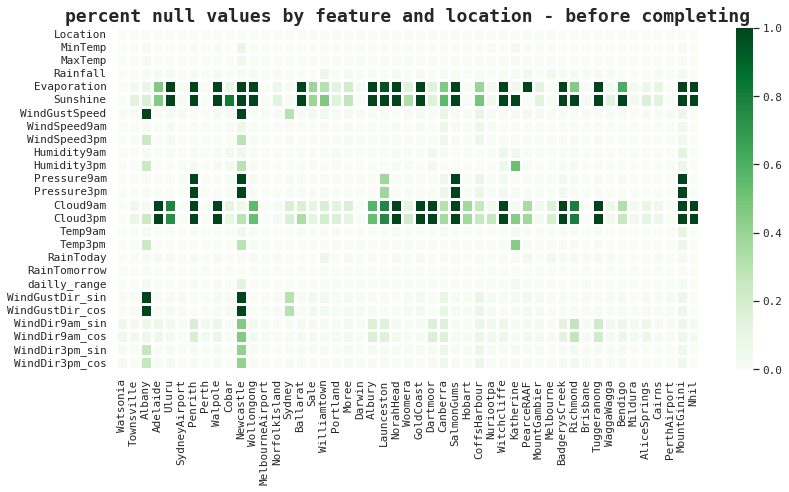

In [28]:
# Step 1: delete all data-points with missing y-label values
print(f"total number of data-points in train = {train.shape[0]} ")
train = train[train[y_label].notna()]
print(f"total number of data-points in after removing data-points with missing values = {train.dropna().shape[0]} ")

plot_nan_heatmap(train, "before completing")

<AxesSubplot:title={'center':'Autocorrelation 1-day'}, ylabel='feature'>

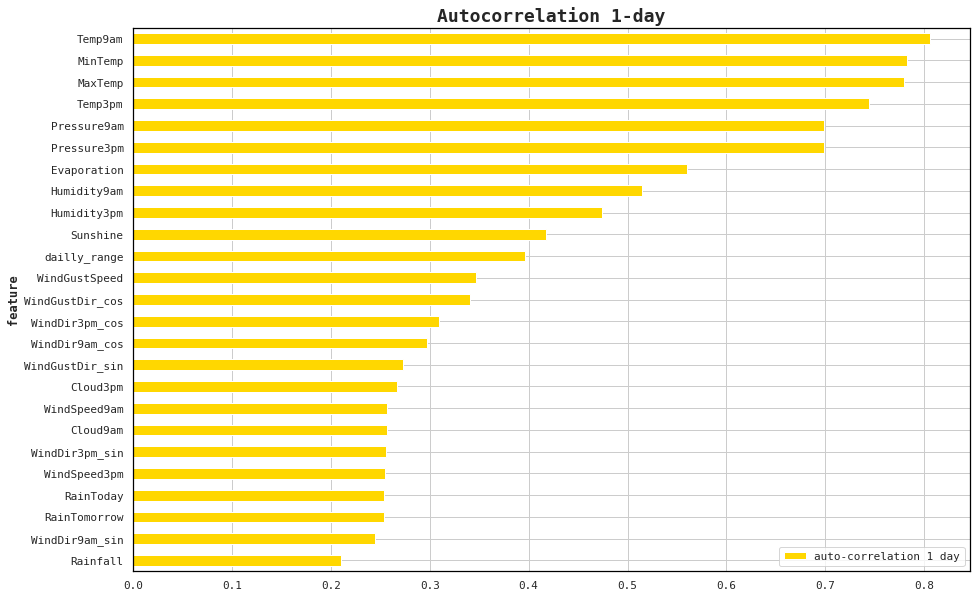

In [29]:
# step 1 - complete by the average of the feature and location in the past n-days

# for most features, the value today has some predictability for the value tomorrow. 
L=[]
for col in train.select_dtypes(np.number).columns:
    mean = 0
    counter = 0
    for location in train["Location"].unique():
        tmp = train[train["Location"] == location].sort_values("Date")
        if not np.isnan(tmp[col].corr(tmp[col].shift(1))):                
            mean += tmp[col].corr(tmp[col].shift(1))
            counter+= 1
    L.append([col, mean/counter])
auto_corr = pd.DataFrame(L, columns = ["feature", "auto-correlation 1 day"])
auto_corr.index = auto_corr["feature"]
auto_corr.sort_values("auto-correlation 1 day", ascending=True).plot(kind='barh', figsize=(15,10),color=color,title="Autocorrelation 1-day")

total number of data-points in train = 48729 


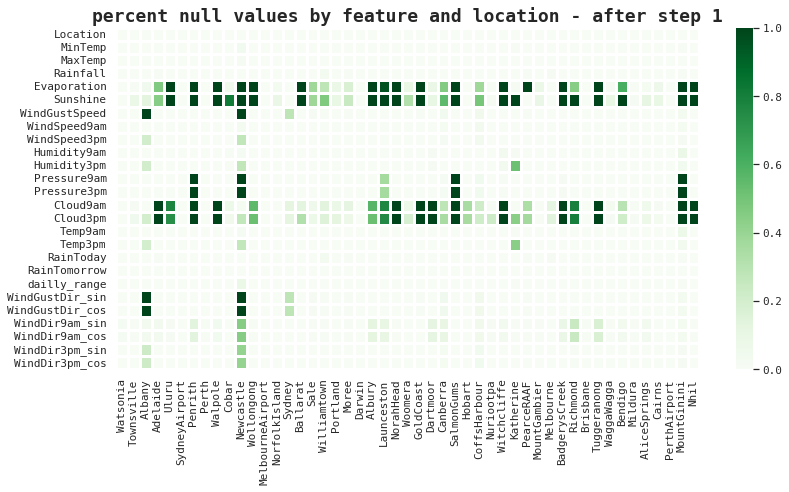

In [30]:
# number of days to look backwords
n_days = 7

# train
for col in train.select_dtypes(np.number).columns:
    for location in train["Location"].unique():
        fillby = train[train["Location"] == location][col].shift(1).rolling(window=n_days).mean(skipna=True)
        train.loc[train['Location'] == location, col] = train[train["Location"] == location][col].fillna(fillby)
print(f"total number of data-points in train = {train.dropna().shape[0]} ")
plot_nan_heatmap(train, "after step 1")

In [ ]:
# step 2 - complete by the historical average of the feature, location and month

# get month of the year 
tmpy_train = train.copy()
months_train = tmpy_train.index.map(lambda x:x.month)

for col in train.select_dtypes(np.number).columns:
    for location in train["Location"].unique():
        for month in range(1,13):
            # create dataframe of monthly averages:
            mask_train = (tmpy_train['Location'] == location) & (months_train == month)
            tmpy_train.loc[mask_train, col] = train[mask_train][col].mean(skipna=True) 
                        
print(f"total number of data-points after step 2 = {train.dropna().shape[0]} ")
# fill the missing values with the average value of the same location-month pair. 
train = train.fillna(tmpy_train)
plot_nan_heatmap(train, "after step 2")

In [ ]:
train = train.dropna(how="any")
test = test.dropna(how="any")
plot_nan_heatmap(train, "after step 3")

In [ ]:
print(f"total number of data-points in train = {train.dropna().shape[0]} ")

## Feature creation / selection  <a class="anchor" id="4"></a>

1) Instead of selecting both morning and afternoon variables for our models, which are correlated, we will drop the morning variables, because it tends to show lower correlation to our y label. Additionally, we will add delta between the afternoon value and the morning value, the un-correlated component of the morning variable (if it has an effect on the y label).

2) There is a defined connection between RainToday and Rainfall (If Rainfall>1$\rightarrow$ RainToday=1 else RainToday=0). We will drop RainToday beacuse it holds less information.

3) teta

4) what we tried about locations.


In [84]:
train.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'dailly_range',
       'WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin',
       'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos', 'theta',
       'theta_bin'],
      dtype='object')

In [ ]:
features = [
    #'MinTemp',
 #'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed3pm',
 'Humidity3pm',
 'Pressure3pm',
 'Cloud3pm',
 'Temp3pm',
 'daily_range',
 'WindGustDir_sin',
 'WindGustDir_cos',
 'WindDir3pm_sin',
 'WindDir3pm_cos',#'Location',
'RainTomorrow']

In [1]:
tmp = train
tmp["daily_range"] = tmp['MaxTemp']-tmp['MinTemp']

temp_avg = tmp.groupby(['Location']).mean()[["daily_range"]]


NameError: name 'train' is not defined

In [102]:
def cart2angle(x, y):
    phi = np.degrees(np.arctan2(y, x)) + 180
    return phi

train['WindGustDir'] = cart2angle(train['WindGustDir_cos'], train['WindGustDir_sin'])
test['WindGustDir'] = cart2angle(test['WindGustDir_cos'], test['WindGustDir_sin'])
train.loc[train['WindGustDir']==360.0, 'WindGustDir'] = 0.0
test.loc[test['WindGustDir']==360.0, 'WindGustDir'] = 0.0

train['WindDir3pm'] = cart2angle(train['WindDir3pm_cos'], train['WindDir3pm_sin'])
test['WindDir3pm'] = cart2angle(test['WindDir3pm_cos'], test['WindDir3pm_sin'])
train.loc[train['WindDir3pm']==360.0, 'WindDir3pm'] = 0.0
test.loc[test['WindDir3pm']==360.0, 'WindDir3pm'] = 0.0

train['WindDir9am'] = cart2angle(train['WindDir9am_cos'], train['WindDir9am_sin'])
test['WindDir9am'] = cart2angle(test['WindDir9am_cos'], test['WindDir9am_sin'])
train.loc[train['WindDir9am']==360.0, 'WindDir9am'] = 0.0
test.loc[test['WindDir9am']==360.0, 'WindDir9am'] = 0.0

In [109]:
# create change-in-time features:
for feature in ["Cloud","Humidity","Pressure", "WindSpeed","WindDir"]:
    train[f"delta_{feature}"] = train[f"{feature}3pm"] - train[f"{feature}9am"]
    test[f"delta_{feature}"] = test[f"{feature}3pm"] - test[f"{feature}9am"]

In [110]:
train["temp_range"] = train["MaxTemp"] - train["MinTemp"]
test["temp_range"] = test["MaxTemp"] - test["MinTemp"]

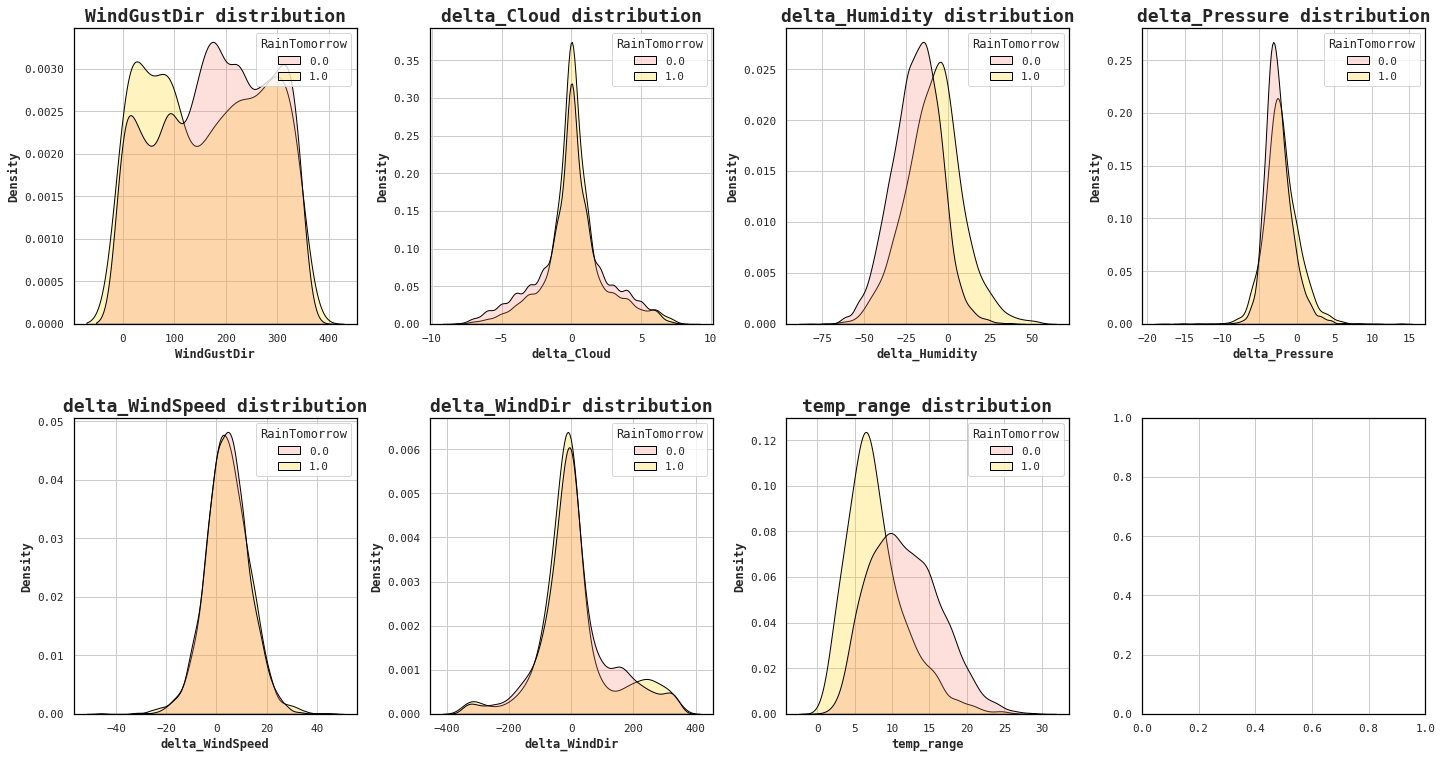

In [108]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20,10.5))
index = 0
ax = ax.flatten()
title = "numerical features distribution"
sample = train.sample(10000).reset_index()

for col, value in sample[['WindGustDir','delta_Cloud', 'delta_Humidity', 'delta_Pressure','delta_WindSpeed','delta_WindDir','temp_range']].items():
        sns.kdeplot(data=sample, x=col,common_norm=False,hue=y_label,
                    palette={1:"gold",0:"salmon"},shade=True, edgecolor="black",
                    ax=ax[index]).set_title(f"{col} distribution", weight="bold")
        index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=3.0)
#plt.savefig(f"./images/{title}.png") 


In [116]:
# select base-features:
features = [
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed3pm',
 'Humidity3pm',
 'Pressure3pm',
 'Cloud3pm',
 'Temp3pm',
 'WindDir3pm',
 'WindGustDir',
 'temp_range',
'RainTomorrow']

features_df = train[features]
features_df_test = test[features]

In [97]:
features_df.columns

Index(['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed3pm',
       'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'Temp3pm', 'WindGustDir',
       'RainTomorrow', 'delta_Cloud', 'delta_Humidity', 'delta_Pressure',
       'delta_WindSpeed', 'temp_range'],
      dtype='object')

The most linear correlated features with RainTomorrow are:
Humidity3pm       -->  0.45 (abs)
Sunshine          -->  0.42 (abs)
Cloud3pm          -->  0.37 (abs)
temp_range        -->  0.34 (abs)
Rainfall          -->  0.23 (abs)
WindGustSpeed     -->  0.23 (abs)
Pressure3pm       -->  0.23 (abs)


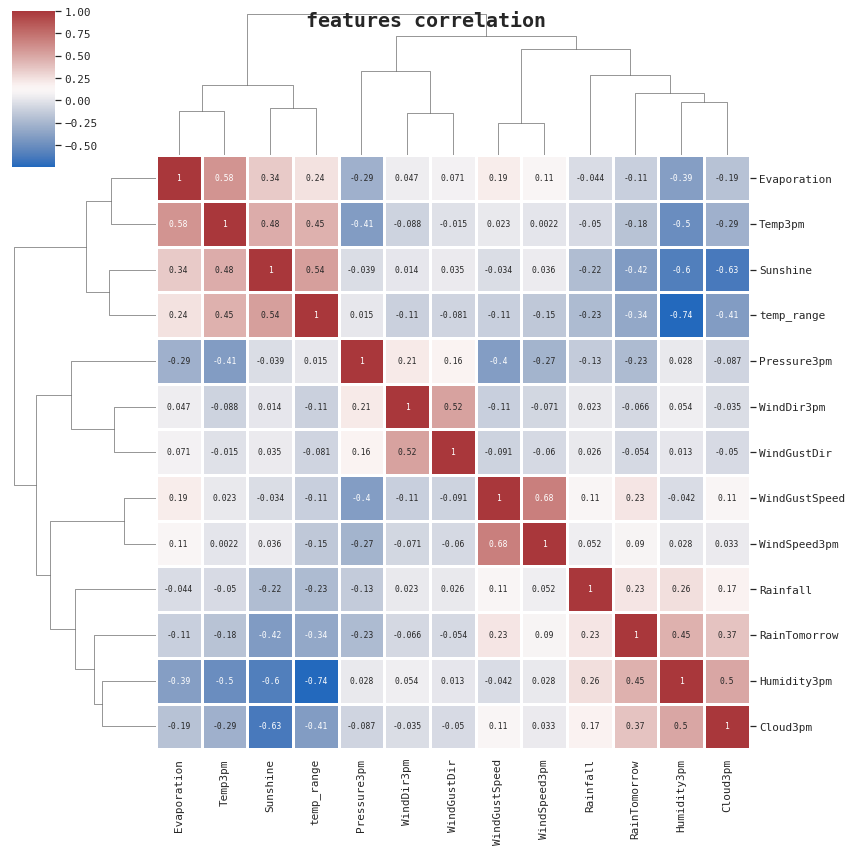

In [113]:
plot_features_correlation(features_df)

Lets check if the new features add value

#### 4.2 Normalize <a class="anchor" id="4.2"></a>

<u>Normalization techniques:</u>
* scaling to a range
* clipping
* log scaling
* precentile
* z-score
* min-max scalling

<u>min-max scaling vs z-score:</u>
* both of them won't change the form of the distribution.
* min-max scaling is
* min-max scaling is bounded - zscore isn't.
* min-max scaling is more sensitive to outliers. (because, The distinction between numbers would blur and they would seem to be less sparse after regeneration on multiplying with the normalization factor)
* min-max scaling is sensitive to the amount of data.
let us demonsrate with example:
$X_{1},...,X_{n}~N(0,1)$
and let us define:$Y_{n} = \max(\{X_{1},..,X_{n}\})$
it's easy to show that $\lim_{n\rightarrow\infty}Y_{n} = \infty$ in O(log(log(n)) (because the probability to sample anomalies values is higher)
if we get twice amount of data or more, $X_{max}-X_{min}$ will be greater. 
Thus, after transforming our data with min-max scale we will get very differnt results in both cases.

In [117]:
y_train, y_test = features_df[[y_label]], features_df_test[[y_label]]
y_train, y_test = y_train.astype('int'),y_test.astype('int')
X_train, X_test = features_df.drop(y_label, axis=1), features_df_test.drop(y_label, axis=1)

In [144]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler(quantile_range=(0.1,0.9)).fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [153]:
mean_vec = X_train.mean(skipna=True)
std_vec = X_train.select_dtypes(np.number).std(skipna=True)

X_train = (X_train - mean_vec) / (std_vec)
X_test = (X_test - mean_vec ) / (std_vec)

# don't apply zscore for categorial values:
cetegorial_features = ["RainToday"]
for feature in cetegorial_features:
    X_train[feature] = features_df[feature]
    X_test[feature] = features_df_test[feature]

IDEAS:
1) mean temp/ max temp,  mean wind speed/max wind speed
2) season

# 5. Random Forest <a class="anchor" id="5"></a>

In [47]:
from sklearn.model_selection import GridSearchCV


# Create the parameter grid based on the results of random search 


# min_samples_leaf: The minimum number of samples required to be at a leaf node.
#                 A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples 
#                 in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.


param_grid = {
    'bootstrap': [True],
    'max_depth': np.arange(3, 10, 2),
    'max_features': int(np.sqrt(len(X_train.columns))) + np.arange(-2,3),
    'min_samples_leaf': np.arange(2, 20, 4),
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50]
}



# Create a based model
clf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 4)

In [229]:
grid_search.fit(X_train, y_train.values.ravel())

Fitting 2 folds for each of 300 candidates, totalling 600 fits


Process LokyProcess-151:
Process LokyProcess-154:
Process LokyProcess-153:
Process LokyProcess-150:
Process LokyProcess-160:
Process LokyProcess-147:
Process LokyProcess-156:
Process LokyProcess-159:
Process LokyProcess-146:
Process LokyProcess-145:
Process LokyProcess-148:
Process LokyProcess-158:
Process LokyProcess-155:
Traceback (most recent call last):
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 222, in __call__
    return self.function(*args, **kwargs)
  File "/Users/hila.dar/opt/anaconda3/li

Traceback (most recent call last):
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/concurrent/futures/_base.py", line 440, in result
    self._condition.wait(timeout)
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/threading.py", line 312, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py", line 841, in fit
    self._run_search(evaluate_candidates)
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py", 

nWithTraceback(e)
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 242, in __init__
    tb = traceback.format_exception(type(exc), exc, tb)
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/traceback.py", line 120, in format_exception
    return list(TracebackException(
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/traceback.py", line 533, in __init__
    self._load_lines()
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/traceback.py", line 547, in _load_lines
    self.__cause__._load_lines()
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/traceback.py", line 543, in _load_lines
    frame.line
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/traceback.py", line 288, in line
    self._line = linecache.getline(self.filename, self.lineno).strip()
  File "/Users/hila.dar/opt/anaconda3/lib/python3.9/linecache.py", line 30, in getline
    lines = getlines(filename, module_globals)
  File "/Users/hila.dar/opt

TypeError: object of type 'NoneType' has no len()

array([0, 1])

In [79]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree


def plot_tree(classifier, max_depth=4):

    fn=X_train.columns
    
    bool2str = lambda x:"Rain" if x==1.0 else "no rain"
    cn = np.array([bool2str(xi) for xi in classifier.classes_])

    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=max(200*max_depth,300))  #make image clearer than default

    tree.plot_tree(classifier,
               feature_names = fn, max_depth=max_depth,
               class_names=cn,
               filled = True);



def evaluate(clf, train=True):
    """ prints and plots a custom score report for a sklearn classifer"""
    class_names = ["no_rain", "rain"]
    if train:
        X,y = X_train, y_train
    else:
        X,y = X_test, y_test
        
    # predict     
    y_predict = clf.predict(X)
    
    name = clf.__class__.__name__
    
    # score report
    print(classification_report(y, y_predict, target_names=class_names))
    
    # balance in prediction report
    print(f"""{y_predict.mean():.2f}% of all samples were classfied as rain (actual = {y.values.mean():.2f}%)""")
    
    # feature importance plot
    typey = "train" if train else "test"
    title = f"features importances for {name}, {typey}"
    cols = [i for i in X_train.columns if i!="Location"]
    feat_importances = pd.Series(clf.feature_importances_, index=cols)
    feat_importances.sort_values(ascending=True).plot(kind='barh',color=color)
    plt.suptitle(title, fontsize=20, weight="bold")
    return f1_score(y, y_predict)

In [122]:
tmp = train[train['Location']=='Sydney'][features]


y_train= tmp[[y_label]].astype('int')
X_train = tmp.drop(y_label, axis=1)

In [123]:
clf = RandomForestClassifier(n_estimators=50,
                         criterion='gini', 
                         class_weight='balanced',
                         max_depth=12, 
                         min_samples_split=5, 
                         min_samples_leaf=10,
                         min_weight_fraction_leaf=0.0, 
                         max_features='auto', 
                         max_leaf_nodes=None, 
                         oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, 
                         ccp_alpha=0.0)
clf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=10, min_samples_split=5,
                       n_estimators=50)

              precision    recall  f1-score   support

     no_rain       0.94      0.90      0.92      2000
        rain       0.74      0.84      0.79       687

    accuracy                           0.88      2687
   macro avg       0.84      0.87      0.85      2687
weighted avg       0.89      0.88      0.89      2687

0.29% of all samples were classfied as rain (actual = 0.26%)


0.7877551020408163

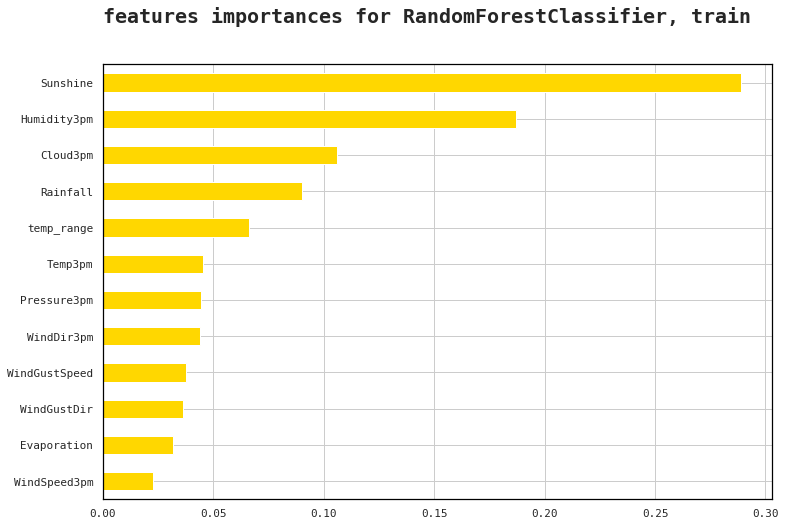

In [124]:
evaluate(clf, train=True)

              precision    recall  f1-score   support

     no_rain       0.93      0.84      0.88      8857
        rain       0.58      0.78      0.66      2463

    accuracy                           0.83     11320
   macro avg       0.75      0.81      0.77     11320
weighted avg       0.85      0.83      0.84     11320

0.29% of all samples were classfied as rain (actual = 0.22%)


0.6627321645547648

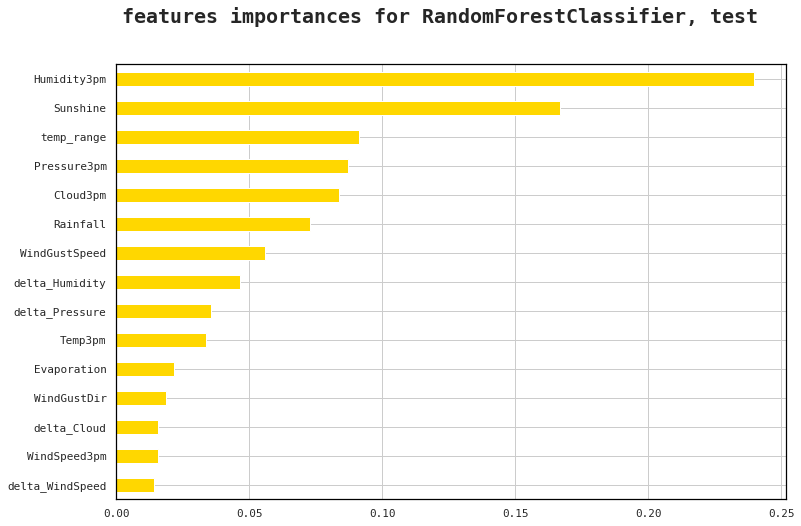

In [115]:
evaluate(clf, train=False)

In [184]:
d = {}
for location in X_train.Location.unique():
    print(location)
    tmp_x = X_train[X_train["Location"] == location]
    
    tmp_y = y_train[X_train["Location"] == location]
    tmp_x = tmp_x.drop("Location",axis=1)
    clf = RandomForestClassifier(n_estimators=10,
                             criterion='gini', 
                             class_weight='balanced',
                             max_depth=7, 
                             min_samples_split=5, 
                             min_samples_leaf=10,
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, 
                             ccp_alpha=0.0)
    clf.fit(tmp_x, tmp_y.values.ravel())
    d[location] = clf

Watsonia
Townsville
SydneyAirport
Perth
Cobar
MelbourneAirport
NorfolkIsland
Sydney
Sale
Williamtown
Portland
Moree
Darwin
Woomera
Canberra
Hobart
CoffsHarbour
Nuriootpa
MountGambier
Melbourne
Brisbane
WaggaWagga
Mildura
AliceSprings
Cairns
PerthAirport


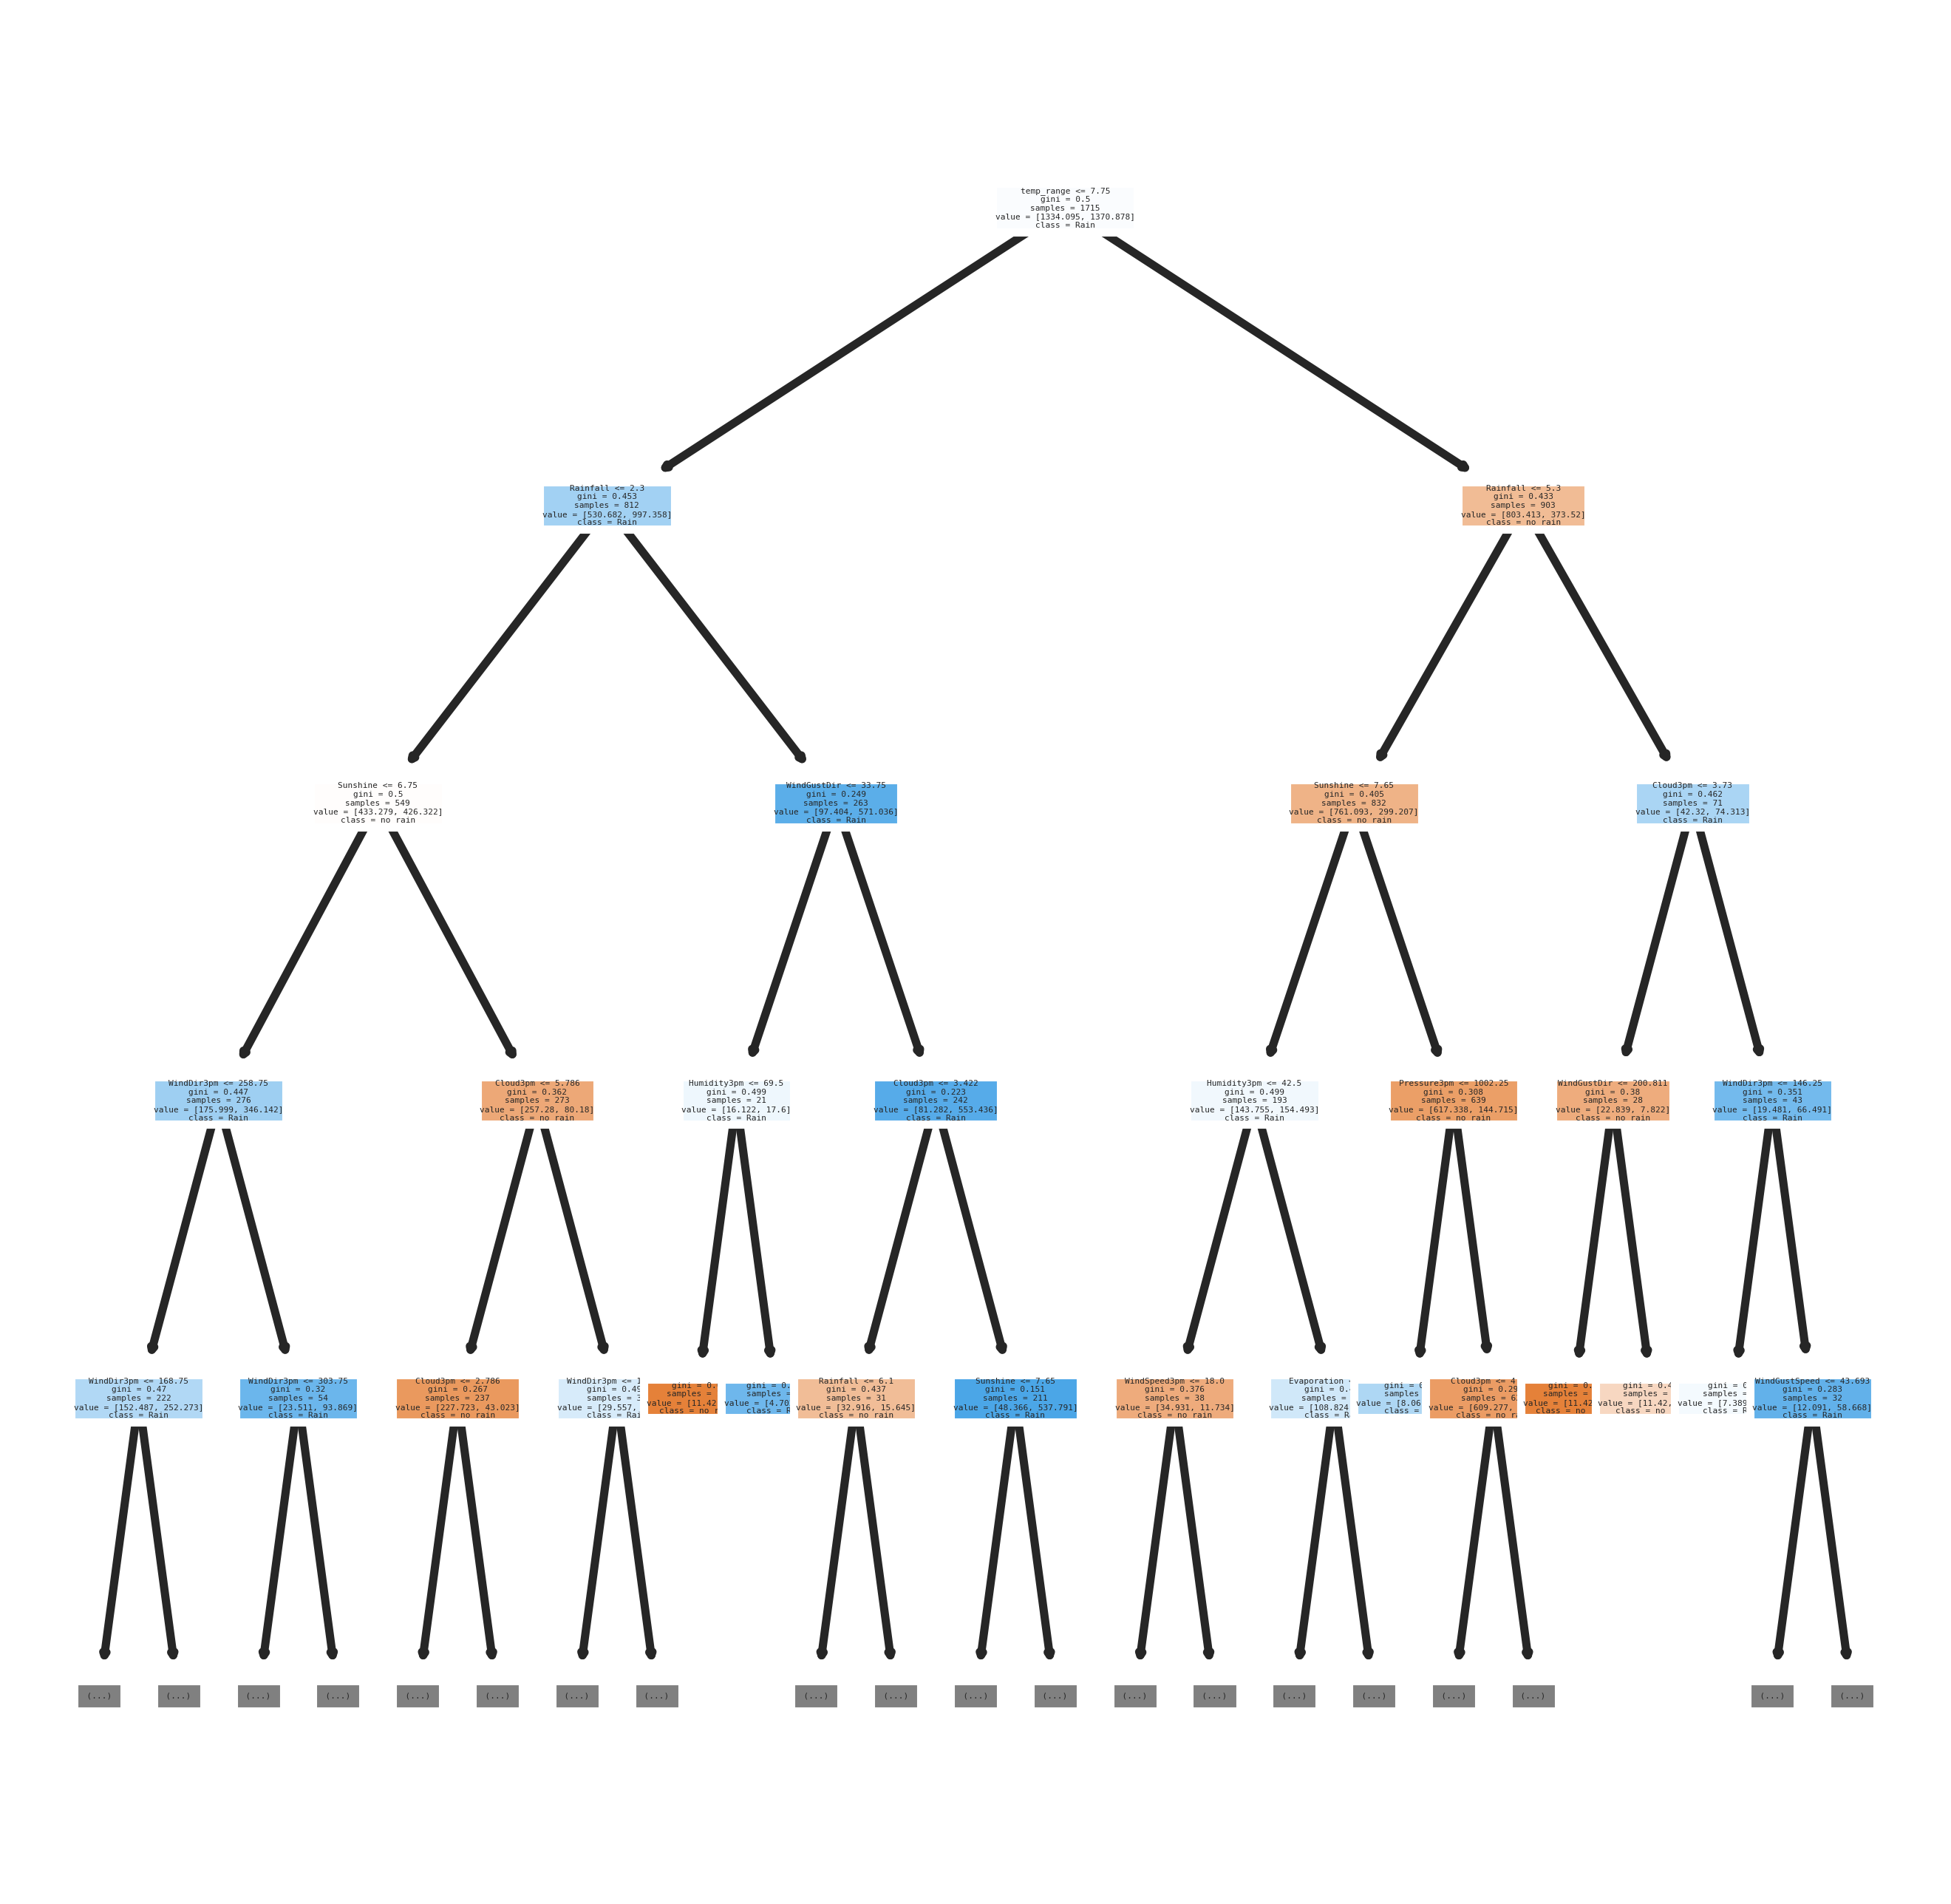

In [125]:
plot_tree(clf.estimators_[0])

In [119]:
evaluate(clf, train=False)

KeyError: "['Location'] not found in axis"

In [120]:
evaluate(clf, train=False)

KeyError: "['Location'] not found in axis"

              precision    recall  f1-score   support

     no_rain       0.87      0.96      0.92      8857
        rain       0.78      0.50      0.61      2463

    accuracy                           0.86     11320
   macro avg       0.83      0.73      0.76     11320
weighted avg       0.85      0.86      0.85     11320

0.14% of all samples were classfied as rain (actual = 0.22%)


0.6105626850937809

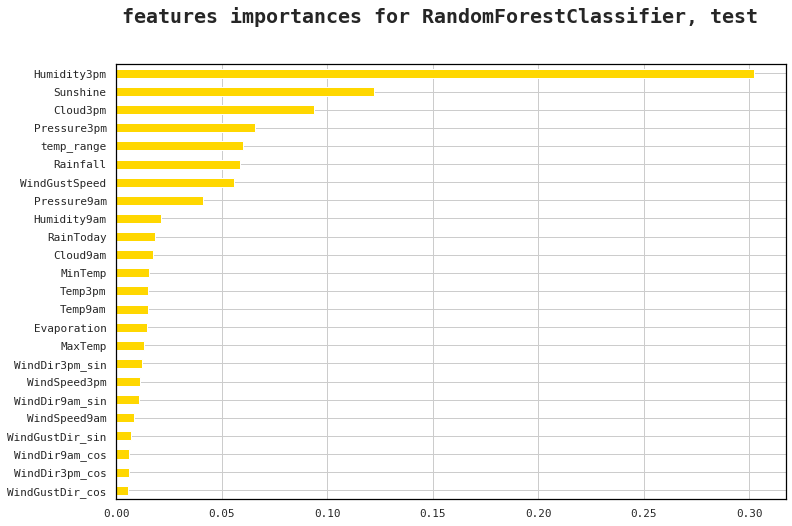

In [52]:
evaluate(clf, train=False)

In [312]:
y_predict = clf.predict(X_train)

In [322]:
tmp = train.copy()

In [323]:
tmp["y_pred"] = y_predict

In [325]:
def get_error(row):
    return (row["y_pred"] == 0) & (row[y_label] == 1)
tmp["error"] = tmp.apply(get_error, axis=1)

In [327]:
sns.kdeplot(data=tmp,x="MinTemp", hue="error" )

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd8a1b8d040> (for post_execute):


KeyboardInterrupt: 

In [1]:
tmpy = tmp.groupby("error").mean().transpose()

tmpy.columns = ["False", "True"]
#tmpy.columns
tmpy["delta"] = np.abs(tmpy["False"] - tmpy["True"])/tmpy["False"]
tmpy.sort_values("delta", ascending=False)


NameError: name 'tmp' is not defined

In [330]:
pd.pivot_table(tmp, values='MinTemp', index=["Location"],
                    columns=["error"], aggfunc=np.mean)

KeyError: 'Location'

              precision    recall  f1-score   support

     no_rain       0.88      0.91      0.90     35136
        rain       0.64      0.57      0.60      9964

    accuracy                           0.83     45100
   macro avg       0.76      0.74      0.75     45100
weighted avg       0.83      0.83      0.83     45100

0.20% of all samples were classfied as rain (actual = 0.22%)


0.6032084421467782

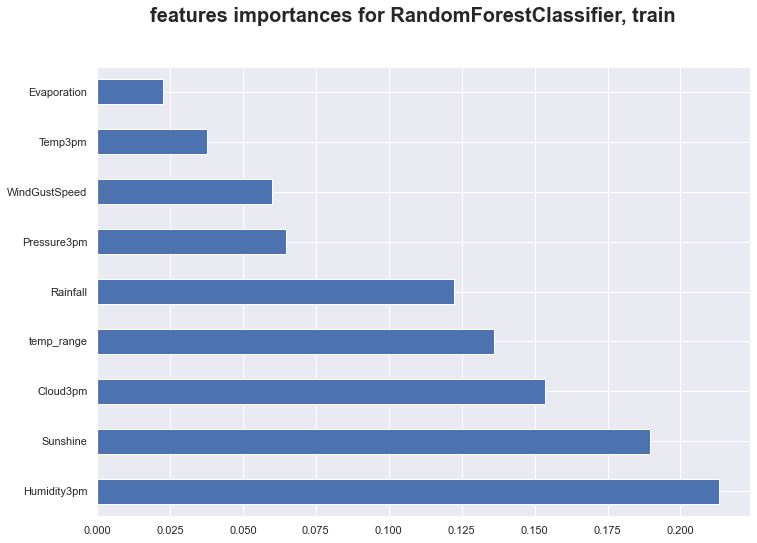

In [112]:
evaluate(clf, train=True)

              precision    recall  f1-score   support

     no_rain       0.88      0.90      0.89      8857
        rain       0.63      0.57      0.60      2463

    accuracy                           0.83     11320
   macro avg       0.75      0.74      0.75     11320
weighted avg       0.83      0.83      0.83     11320

0.20% of all samples were classfied as rain (actual = 0.22%)


0.5963049479719686

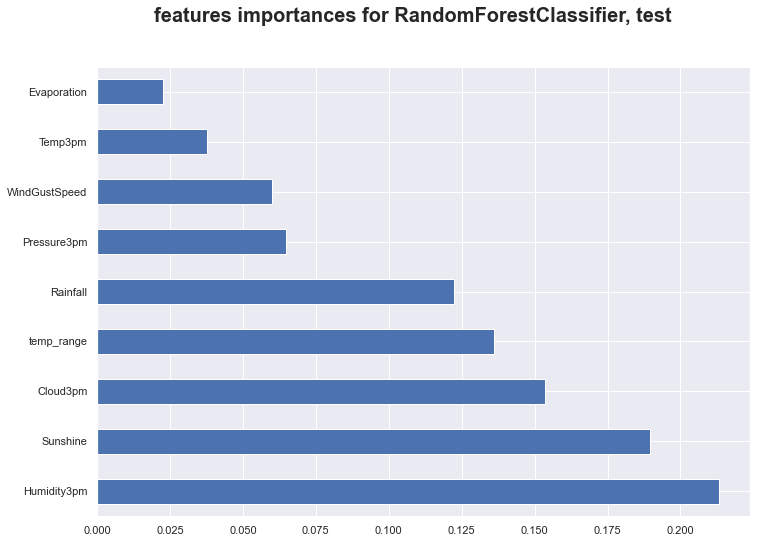

In [113]:
evaluate(clf, train=False)

              precision    recall  f1-score   support

     no_rain       0.91      0.92      0.92     48884
        rain       0.71      0.69      0.70     13712

    accuracy                           0.87     62596
   macro avg       0.81      0.80      0.81     62596
weighted avg       0.87      0.87      0.87     62596

0.21% of all samples were classfied as rain (actual = 0.22%)


0.6972307464783526

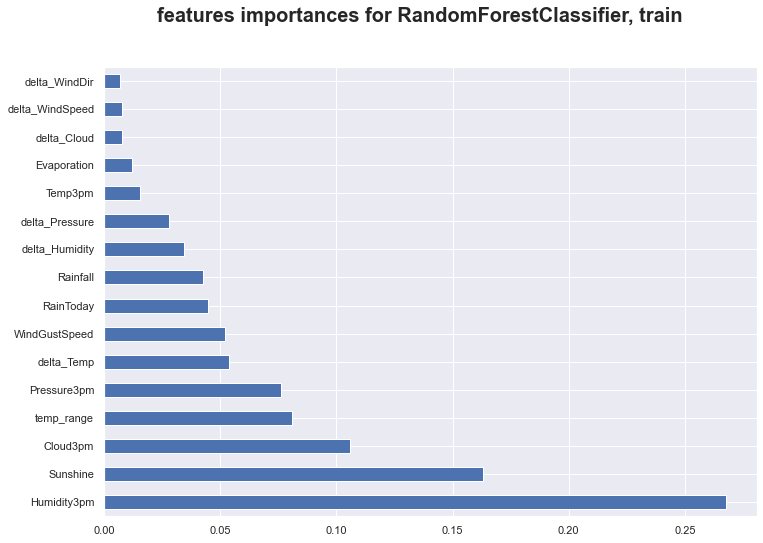

In [295]:
evaluate(clf)

In [350]:
L = []
K = []

for j in range(1,15):
    clf = RandomForestClassifier(n_estimators=25,
                             criterion='gini', 
                             class_weight={0: 1,1:2},
                             max_depth=3, 
                             min_samples_split=5, 
                             min_samples_leaf=10,
                             min_weight_fraction_leaf=0.0, 
                             max_features=j, 
                             max_leaf_nodes=None, 
                             oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=True, 
                             ccp_alpha=0.0)
    clf.fit(X_train, y_train.values.ravel())
    pred = clf.predict(X_test)
    L.append([j,precision_score(y_test, pred), recall_score(y_test, pred), accuracy_score(y_test, pred), f1_score(y_test, pred) ])
    pred = clf.predict(X_train)
    K.append([j,precision_score(y_train, pred), recall_score(y_train, pred), accuracy_score(y_train, pred), f1_score(y_train, pred) ])
#clf.fit(X_over, y_over.values.ravel())

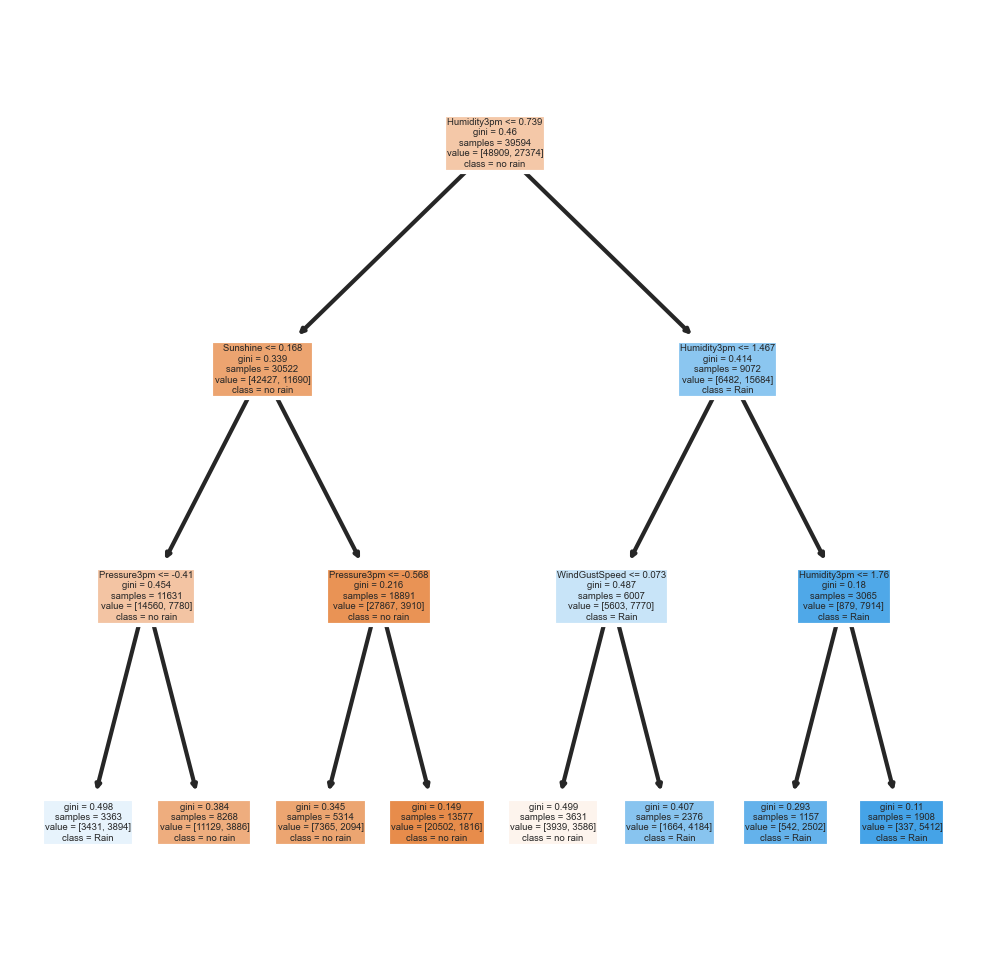

In [337]:
tmp

i  precision_score  recall_score  accuracy_score  f1_score
0  2         0.625170      0.558668        0.831095  0.590051
1  3         0.629383      0.575721        0.833922  0.601357
2  4         0.637382      0.600893        0.838781  0.618600
3  5         0.632860      0.633374        0.840283  0.633117
4  6         0.645816      0.632968        0.844611  0.639327
5  7         0.641598      0.665043        0.846290  0.653110
6  8         0.657097      0.659765        0.851060  0.658428
7  9         0.655466      0.657328        0.850265  0.656396

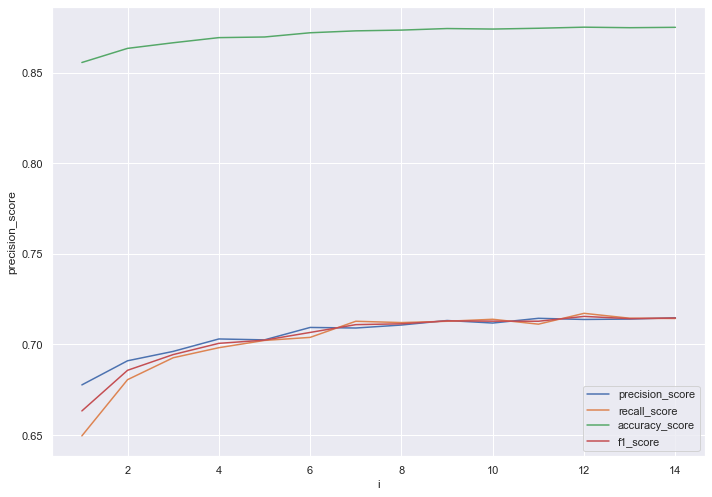

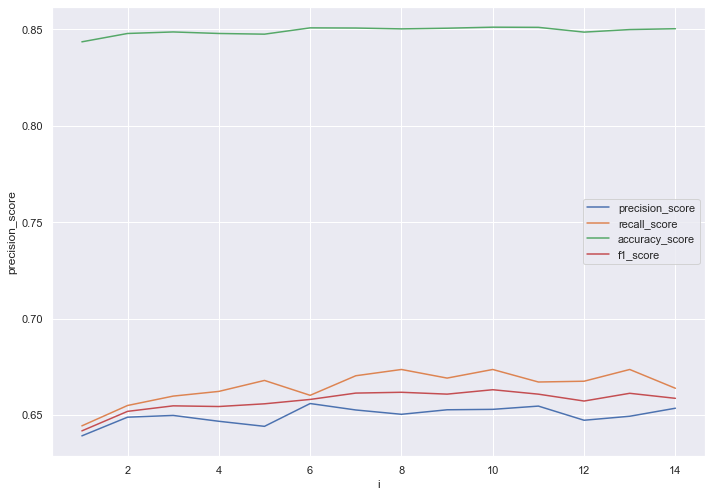

In [338]:
tmp_train = pd.DataFrame(K, columns = ["i","precision_score", "recall_score","accuracy_score","f1_score"])
tmp_test = pd.DataFrame(L, columns = ["i","precision_score", "recall_score","accuracy_score","f1_score"])

for j in ["precision_score", "recall_score","accuracy_score","f1_score"]:
    sns.lineplot(data=tmp_train, x="i", y=j,label=j)
plt.show()
for j in ["precision_score", "recall_score","accuracy_score","f1_score"]:
    sns.lineplot(data=tmp_test, x="i", y=j,label=j)

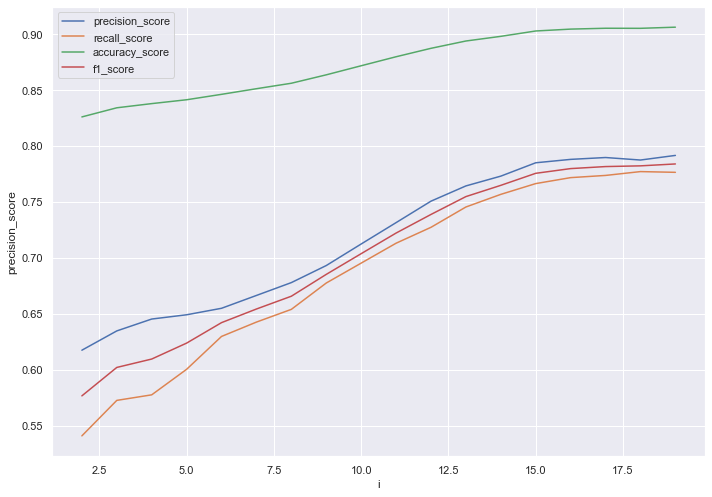

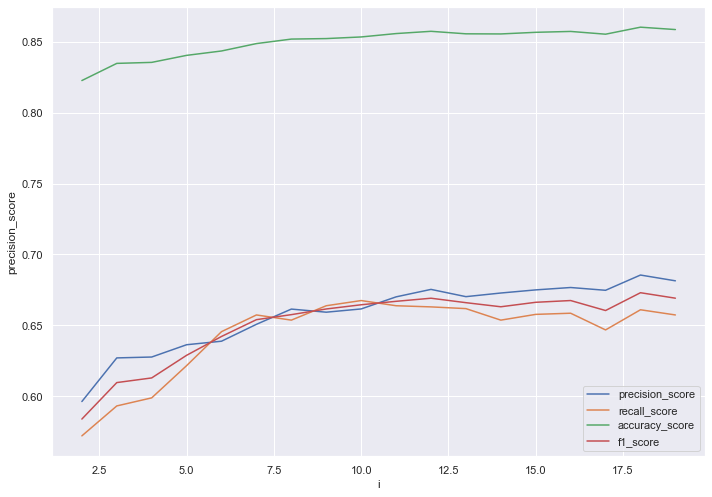

In [317]:
tmp_train = pd.DataFrame(K, columns = ["i","precision_score", "recall_score","accuracy_score","f1_score"])
tmp_test = pd.DataFrame(L, columns = ["i","precision_score", "recall_score","accuracy_score","f1_score"])

for j in ["precision_score", "recall_score","accuracy_score","f1_score"]:
    sns.lineplot(data=tmp_train, x="i", y=j,label=j)
plt.show()
for j in ["precision_score", "recall_score","accuracy_score","f1_score"]:
    sns.lineplot(data=tmp_test, x="i", y=j,label=j)

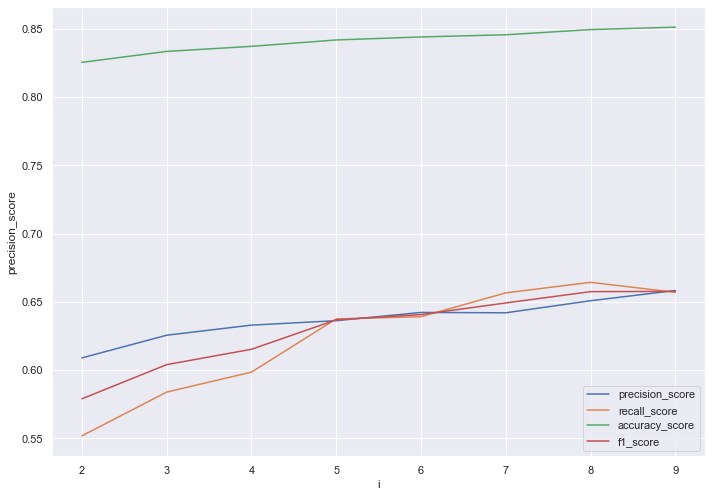

In [293]:
tmp = pd.DataFrame(L, columns = ["i","precision_score", "recall_score","accuracy_score","f1_score"])
for j in ["precision_score", "recall_score","accuracy_score","f1_score"]:
    sns.lineplot(data=tmp, x="i", y=j,label=j)

In [ ]:
tmp

In [245]:
for j in range(100):
    if clf.estimators_[j].feature_importances_[5]>0:
        break

In [300]:
X_train["RainToday"] = X_train["RainToday"].apply(lambda x:1 if x>0.5 else 0)

In [302]:
X_train["RainToday"].unique()

array([0, 1])

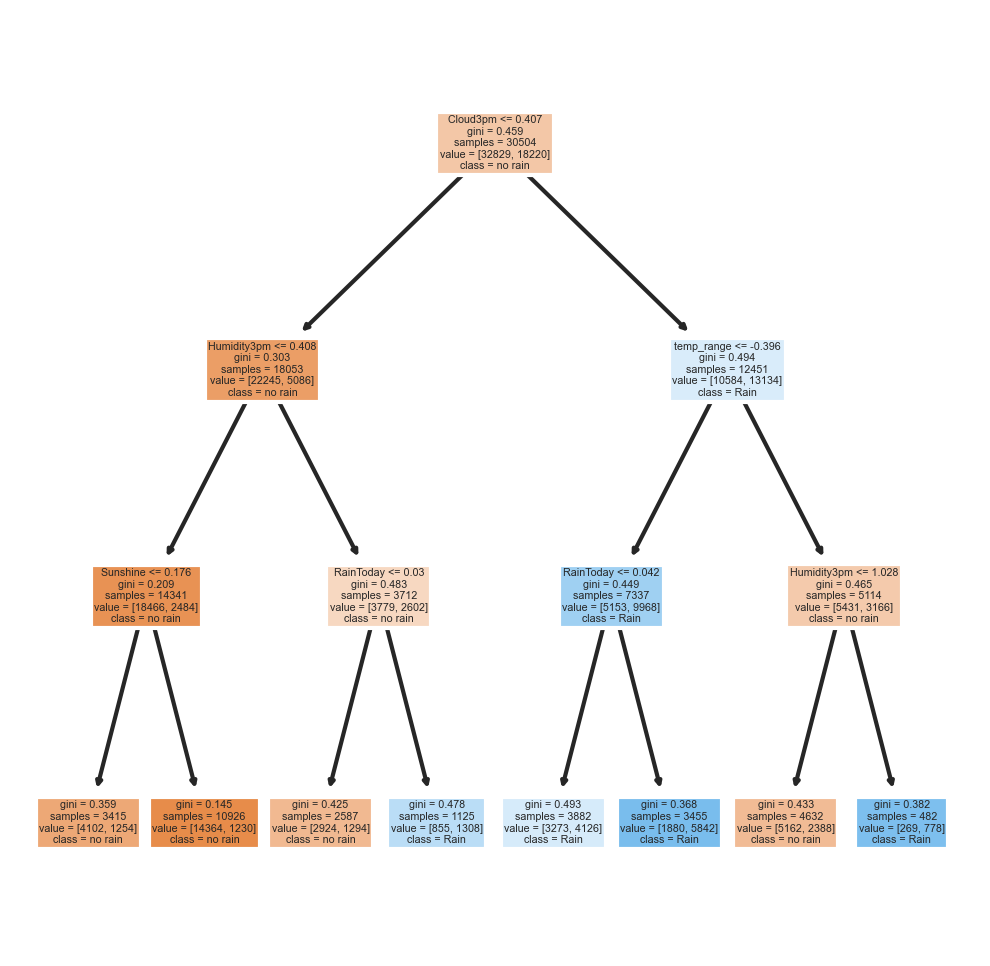

In [250]:
plot_tree(clf.estimators_[2])

In [63]:


class_names = ["no_rain", "rain"]
y_predict = clf.predict(X_train)
print(classification_report(y_train, y_predict, target_names=class_names))


# def print_score(clf=clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
print(f"""train acc: {clf.score(X_train, y_train)}
test acc: {clf.score(X_test, y_test)}
train precision: """)


y_predict = clf.predict(X_test)
print(classification_report(y_test, y_predict, target_names=class_names))

              precision    recall  f1-score   support

     no_rain       0.92      0.93      0.92     48884
        rain       0.72      0.70      0.71     13712

    accuracy                           0.88     62596
   macro avg       0.82      0.81      0.82     62596
weighted avg       0.87      0.88      0.87     62596

train acc: 0.8755351779666433
test acc: 0.8506183745583039
train precision: 
              precision    recall  f1-score   support

     no_rain       0.90      0.91      0.90      8857
        rain       0.66      0.65      0.65      2463

    accuracy                           0.85     11320
   macro avg       0.78      0.78      0.78     11320
weighted avg       0.85      0.85      0.85     11320



0.21519434628975265

In [579]:
y_test.mean()

0.21757950530035336

1) Predict probability
2) RandomForestClassifier
3) class weigh unbalanced

<AxesSubplot:>

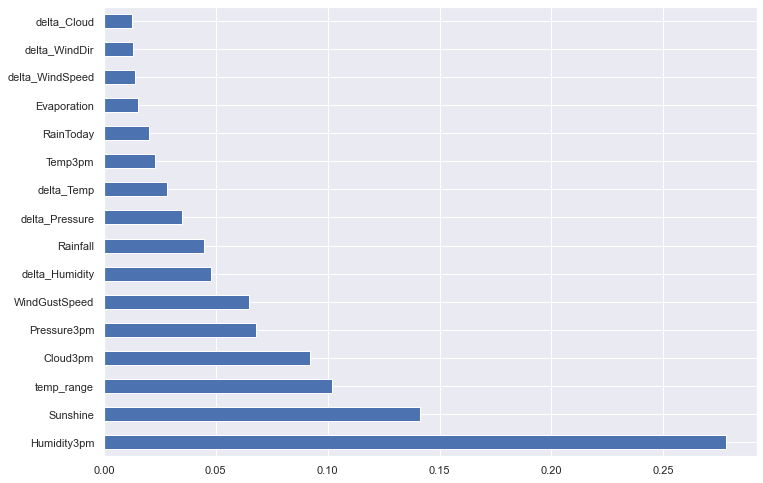

In [65]:
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).plot(kind='barh')

In [476]:
clf

BalancedRandomForestClassifier(max_depth=15, max_features=8, n_estimators=50,
                               random_state=2022, sampling_strategy='all',
                               warm_start=True)

In [66]:
tmp = X_train.copy()
tmp["y_pred"] = clf.predict(X_train)

<AxesSubplot:xlabel='Sunshine', ylabel='temp_range'>

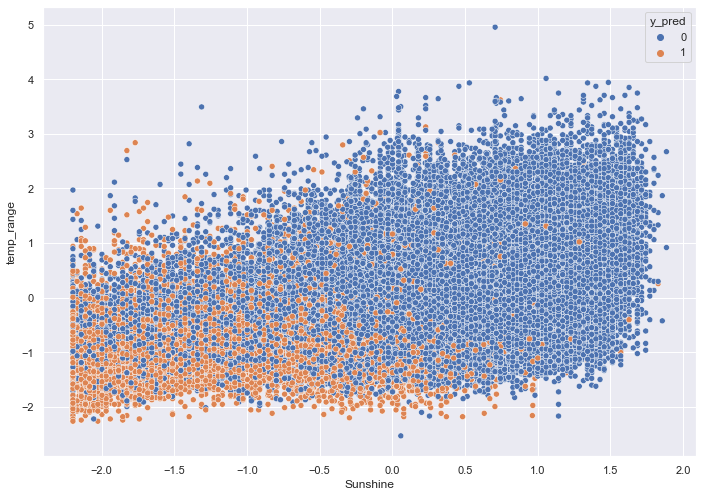

In [69]:
sns.scatterplot(data=tmp, x="Sunshine", y="temp_range", hue="y_pred")

<AxesSubplot:xlabel='Sunshine', ylabel='temp_range'>

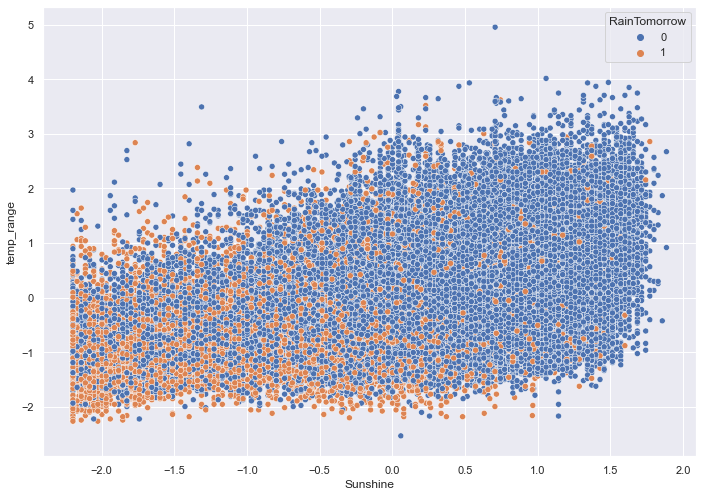

In [70]:
tmp[y_label] = y_train
sns.scatterplot(data=tmp, x="Sunshine", y="temp_range", hue=y_label)

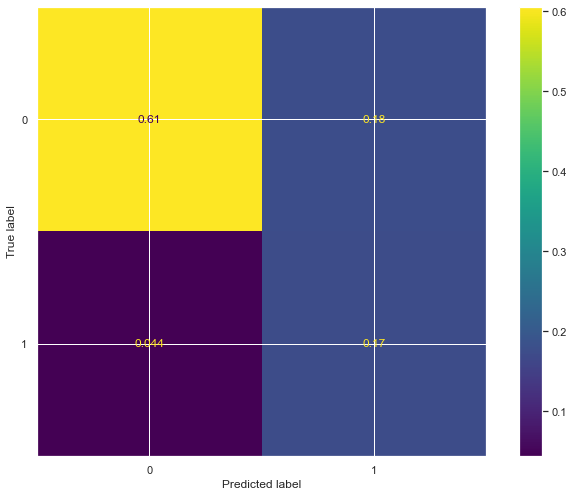

In [497]:
dist = ConfusionMatrixDisplay()
dist.plot()
plt.show()




In [456]:
print(0.13/(0.13+0.043))
print(0.74/ (0.74+0.092))
print(0.13/ (0.13+0.092))
print(0.74/ (0.74+0.043))

0.7514450867052024
0.889423076923077
0.5855855855855856
0.9450830140485312


In [457]:
print(f1_score(y_train, clf.predict(X_train)))


0.9909896033885252


0.6510989010989011

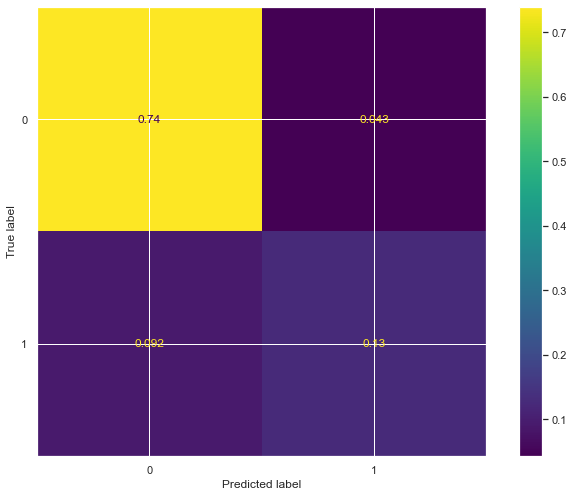

In [443]:


#with completing

In [ ]:
mse + lamda |b| ..... b'= b/1000

In [ ]:
pred_df = pd.DataFrame({"act":y_test_tmp, "pred":clf.predict(X_test_tmp)})

In [ ]:
pred_df[pred_df["pred"]==1].mean()

The conclusion is that it’s quite difficult to predict rainfall tomorrow based on using only variables from the previous day, as we don’t seem to be able to pick up the large swings that tend to occur. However, if we bring in current day variables, our forecast accuracy increases substantially. What this suggests is that there is likely a set of conditions which exist to cause rainfall and when these all simultaneously occur, we get the magic of rain. This is when things like humidity/pressure/cloud/wind speed all play in, as they all tie into the properties of water and impact on weather patterns.

## 5.3 Arima by location <a class="anchor" id="5.3"></a>

In [471]:
from sklearn import preprocessing
df=data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df['Year-Mon'] = [x.strftime("%Y-%m") for x in df['Date']]

cat_f = [x for x in df.columns if df[x].dtype == 'object']

for name in cat_f:
    enc = preprocessing.LabelEncoder()
    enc.fit(list(df[name].values.astype('str')) + list(df[name].values.astype('str')))
    df[name] = enc.transform(df[name].values.astype('str'))


In [474]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

ModuleNotFoundError: No module named 'keras'